# Deep Evidential Regression
Deep Evidential Regression (DER) is a technique that trains a single deterministic network to learn four outputs which characterize evidential priors over the original Gaussian likelihood function. We learn the parameters of a joint conjugate prior (Normal-Inverse-Gamma) that hierarchically parameterizes the Gaussian likelihood.

Following - https://arxiv.org/abs/1910.02600

With a modified loss function and calculation of aleatoric and epistemic uncertainty from - https://arxiv.org/abs/2205.10060 

The loss function modification and DER and SDER models are taken from - https://github.com/pasteurlabs/unreasonable_effective_der/tree/main

In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from scripts import train, models, analysis, io

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [33]:
DER_TYPE = 'SDER'  # 'sDER'
noise = 'medium'
# model_name will be used to save the model by checkpoint
model_name = DER_TYPE + '_noise_' + noise
norm = 'False' # if you normalize, rn the normalized version doesn't work
n_epochs = 500
BATCH_SIZE = 100

In [34]:
if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
    DERLayer = models.DERLayer
    loss_der = models.loss_der
if DER_TYPE == 'SDER':
    #The below were the numbers for SDER originally
    #LR = .005    # learning rate
    #COEFF = 2.   # lambda
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Load linear data from h5
There are multiple noise options, so define sigma first.

In [35]:
if noise == 'low':
    sigma = 1
if noise == 'high':
    sigma = 10
size_df = 1000

In [36]:
loader = io.DataLoader()

In [37]:
data = loader.load_data_h5('linear_sigma_'+str(sigma)+'_size_'+str(size_df))

In [38]:
len_df = len(data['params'][:,0].numpy())
len_x = len(data['inputs'].numpy())
ms_array = np.repeat(data['params'][:,0].numpy(), len_x)
bs_array = np.repeat(data['params'][:,1].numpy(), len_x)
xs_array = np.tile(data['inputs'].numpy(), len_df)
ys_array = np.reshape(data['output'].numpy(), (len_df * len_x))

print('shapes',
      np.shape(ms_array),
      np.shape(bs_array),
      np.shape(xs_array),
      np.shape(ys_array))

shapes (101000,) (101000,) (101000,) (101000,)


<Figure size 640x480 with 0 Axes>

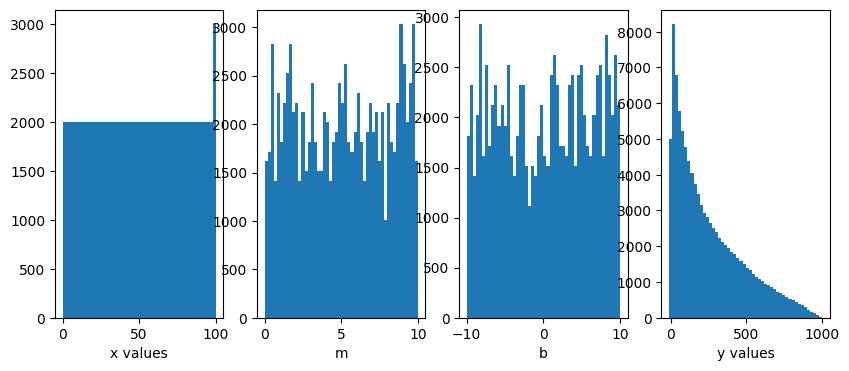

In [39]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [40]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [41]:
if norm == 'True':
    print('normalized version', norm)
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    print('not normalizing')
    model_inputs = inputs
    model_outputs = ys_array

not normalizing


<Figure size 640x480 with 0 Axes>

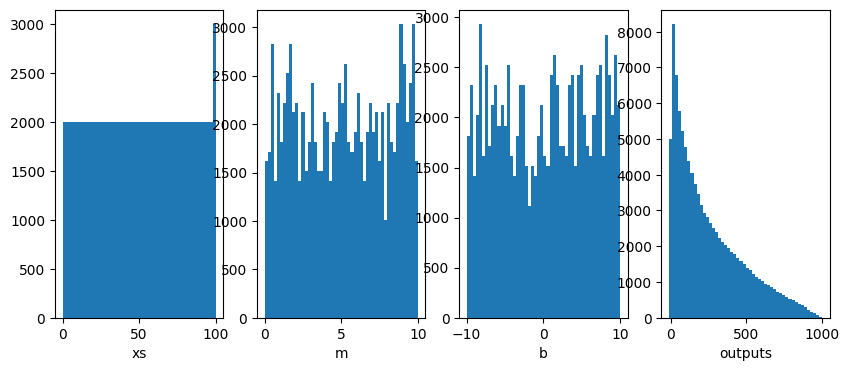

In [42]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


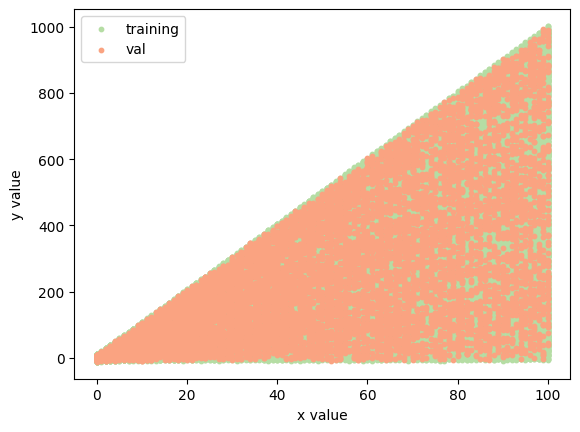

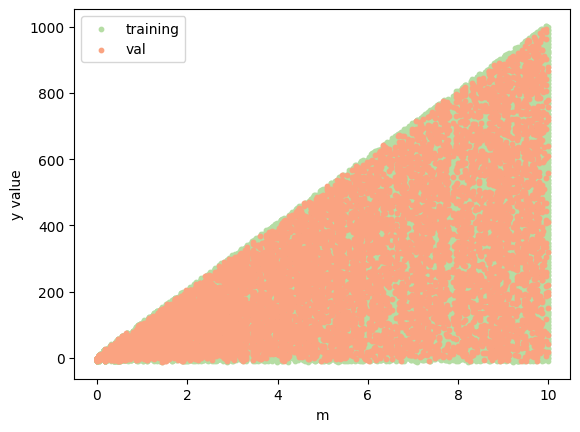

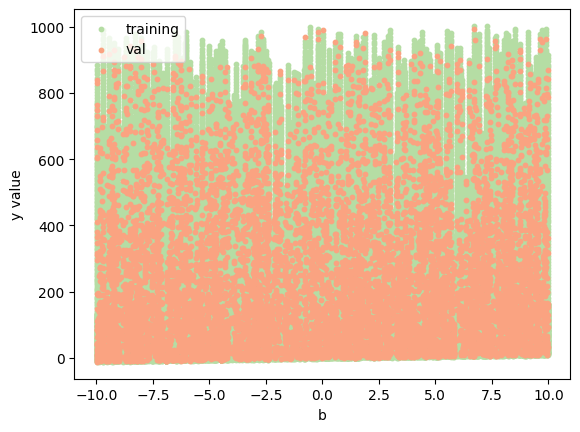

In [43]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [44]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


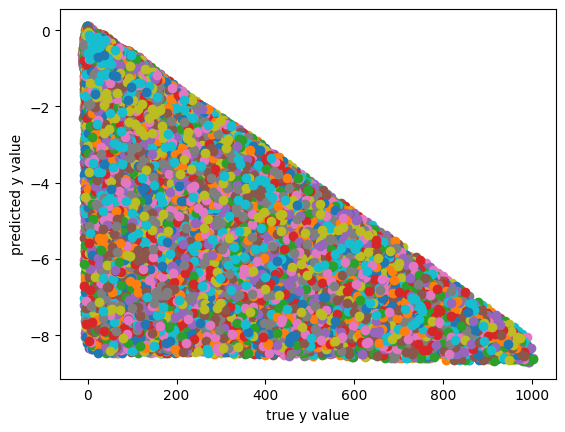

In [45]:
# plot what we're trying to predict
counter = 0
model, loss = train.model_setup_DER(DER_TYPE, DEVICE)
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(DEVICE), y.to(DEVICE))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()

    
    plt.scatter(y, pred[:,0], linestyle='None')
    
    counter += 1
plt.xlabel('true y value')
plt.ylabel('predicted y value')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()

[INFO] training the network...
saving checkpoints?
True
[]
starting here 0
epoch 0 0.0


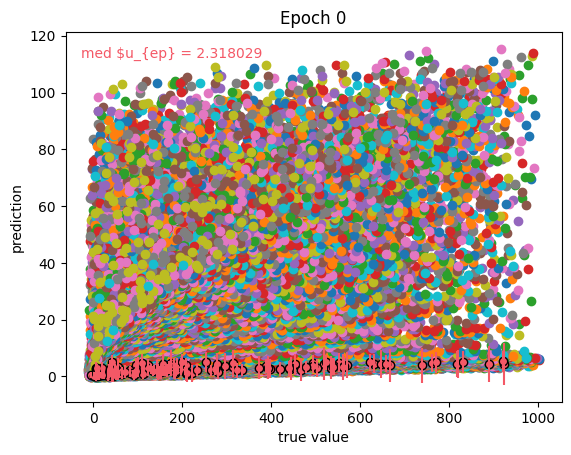

new best loss 10.510929107666016 in epoch 0
epoch 1 0.0
new best loss 10.027220726013184 in epoch 1
epoch 2 0.0
new best loss 9.576818466186523 in epoch 2
epoch 3 0.01
new best loss 8.864482879638672 in epoch 3
epoch 4 0.01
new best loss 7.920047283172607 in epoch 4
epoch 5 0.01


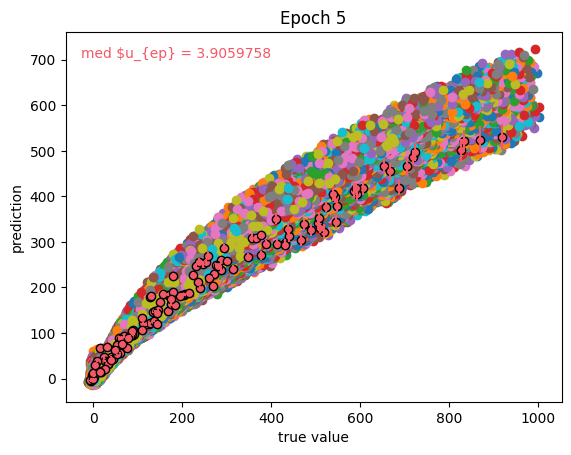

new best loss 7.13283634185791 in epoch 5
epoch 6 0.01
new best loss 6.72944450378418 in epoch 6
epoch 7 0.01
new best loss 6.439085006713867 in epoch 7
epoch 8 0.02
new best loss 6.283829212188721 in epoch 8
epoch 9 0.02
new best loss 6.036113739013672 in epoch 9
epoch 10 0.02


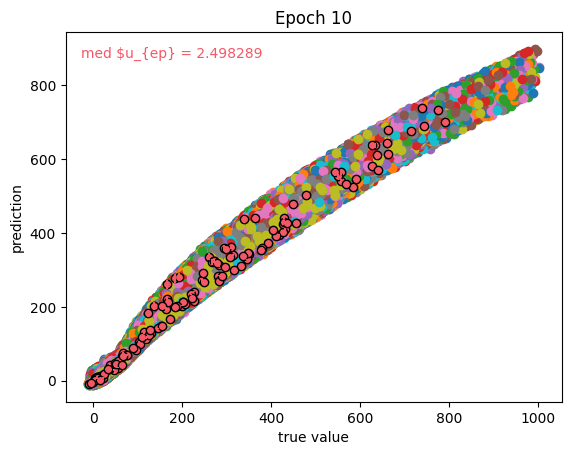

new best loss 5.844070911407471 in epoch 10
epoch 11 0.02
new best loss 5.7768778800964355 in epoch 11
epoch 12 0.02
new best loss 5.473066329956055 in epoch 12
epoch 13 0.03
new best loss 5.279131889343262 in epoch 13
epoch 14 0.03
new best loss 5.07516622543335 in epoch 14
epoch 15 0.03


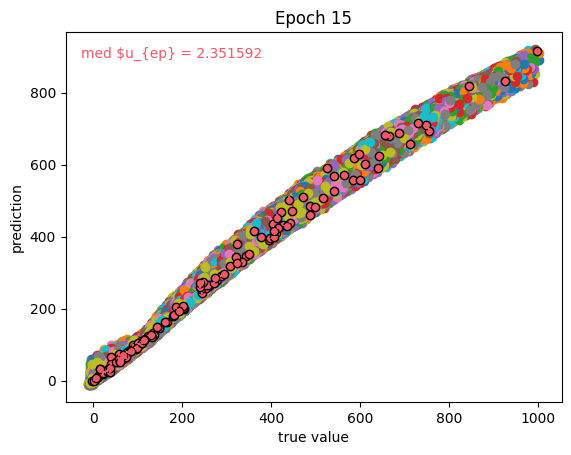

new best loss 4.893196105957031 in epoch 15
epoch 16 0.03
epoch 17 0.03
new best loss 4.374501705169678 in epoch 17
epoch 18 0.04
new best loss 4.281287670135498 in epoch 18
epoch 19 0.04
new best loss 4.021379470825195 in epoch 19
epoch 20 0.04


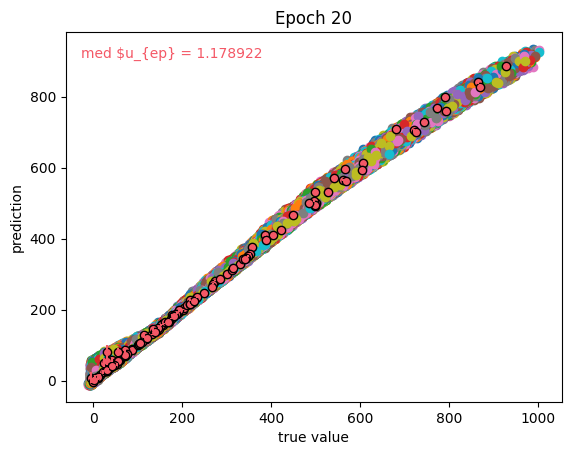

new best loss 3.8455615043640137 in epoch 20
epoch 21 0.04
new best loss 3.512769937515259 in epoch 21
epoch 22 0.04
epoch 23 0.05
new best loss 3.2725019454956055 in epoch 23
epoch 24 0.05
epoch 25 0.05


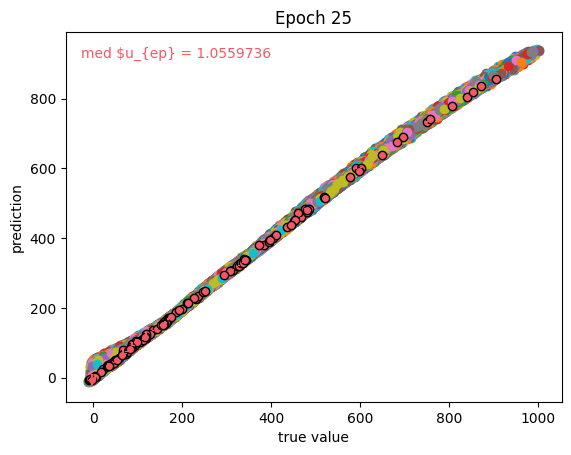

new best loss 3.2665934562683105 in epoch 25
epoch 26 0.05
new best loss 2.8840155601501465 in epoch 26
epoch 27 0.05
epoch 28 0.06
new best loss 2.843738079071045 in epoch 28
epoch 29 0.06
epoch 30 0.06


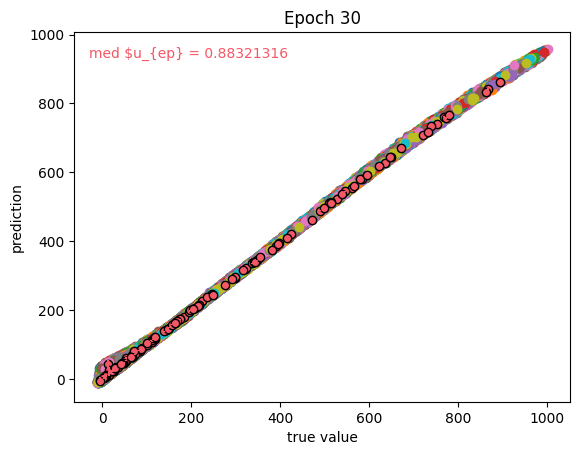

new best loss 2.8315486907958984 in epoch 30
epoch 31 0.06
epoch 32 0.06
new best loss 2.6436715126037598 in epoch 32
epoch 33 0.07
new best loss 2.473984718322754 in epoch 33
epoch 34 0.07
epoch 35 0.07


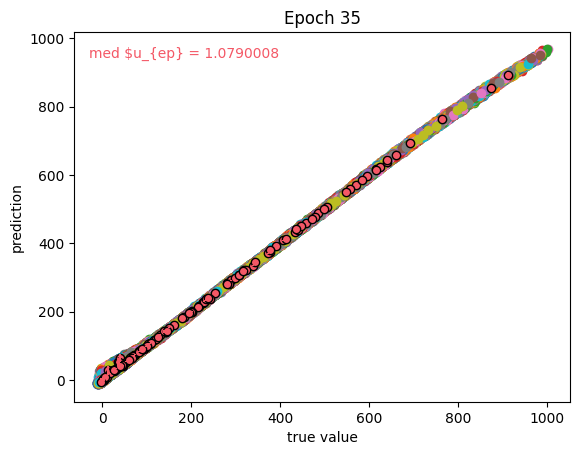

new best loss 2.444694757461548 in epoch 35
epoch 36 0.07
new best loss 2.3895773887634277 in epoch 36
epoch 37 0.07
epoch 38 0.08
epoch 39 0.08
epoch 40 0.08


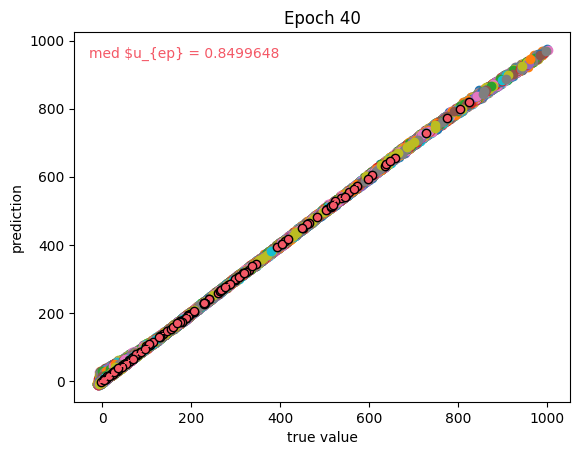

new best loss 2.2185959815979004 in epoch 40
epoch 41 0.08
epoch 42 0.08
new best loss 2.1935691833496094 in epoch 42
epoch 43 0.09
epoch 44 0.09
epoch 45 0.09


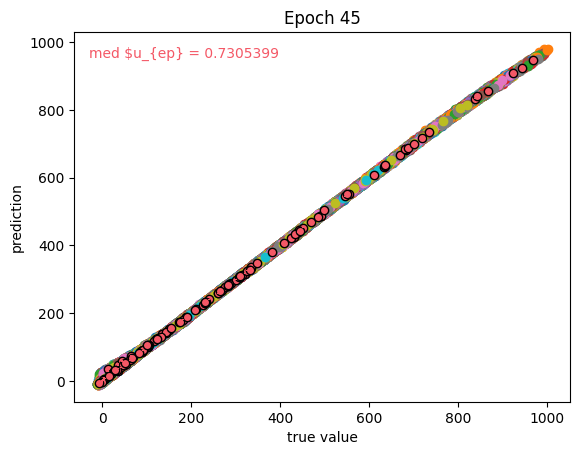

epoch 46 0.09
epoch 47 0.09
epoch 48 0.1
epoch 49 0.1
epoch 50 0.1


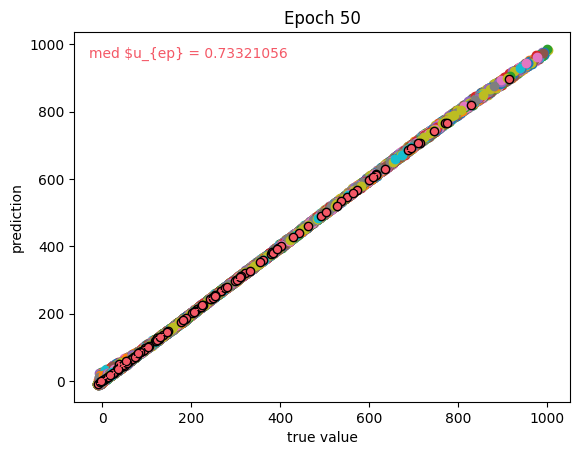

epoch 51 0.1
epoch 52 0.1
epoch 53 0.11
new best loss 2.121629238128662 in epoch 53
epoch 54 0.11
epoch 55 0.11


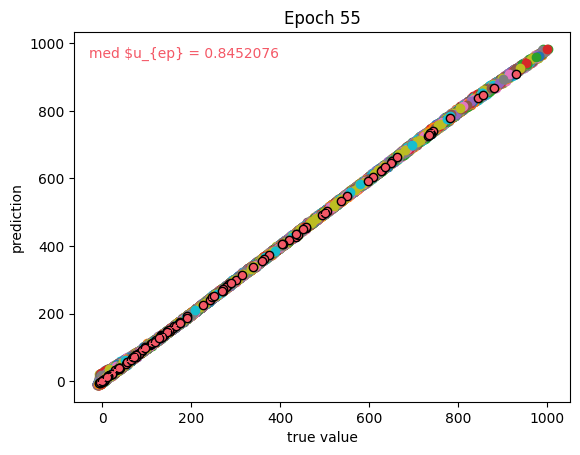

new best loss 2.0977838039398193 in epoch 55
epoch 56 0.11
epoch 57 0.11
epoch 58 0.12
new best loss 2.0037224292755127 in epoch 58
epoch 59 0.12
new best loss 1.9989500045776367 in epoch 59
epoch 60 0.12


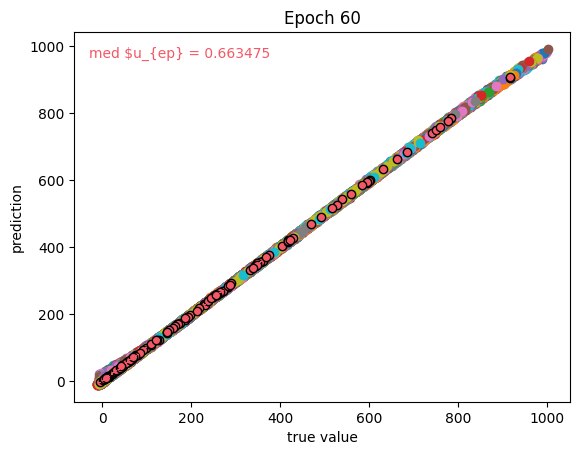

epoch 61 0.12
epoch 62 0.12
epoch 63 0.13
new best loss 1.9611666202545166 in epoch 63
epoch 64 0.13
epoch 65 0.13


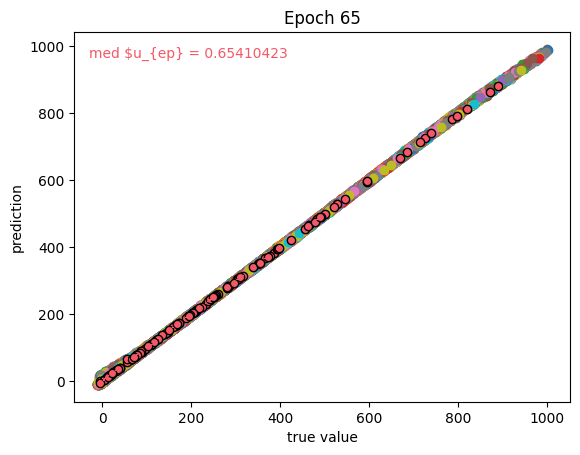

epoch 66 0.13
new best loss 1.8903741836547852 in epoch 66
epoch 67 0.13
epoch 68 0.14
epoch 69 0.14
epoch 70 0.14


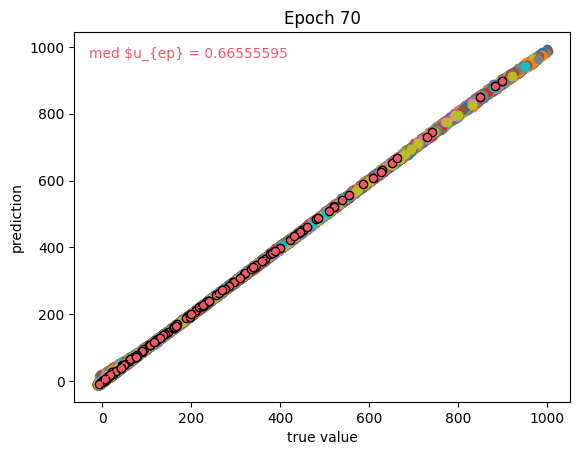

epoch 71 0.14
epoch 72 0.14
epoch 73 0.15
epoch 74 0.15
epoch 75 0.15


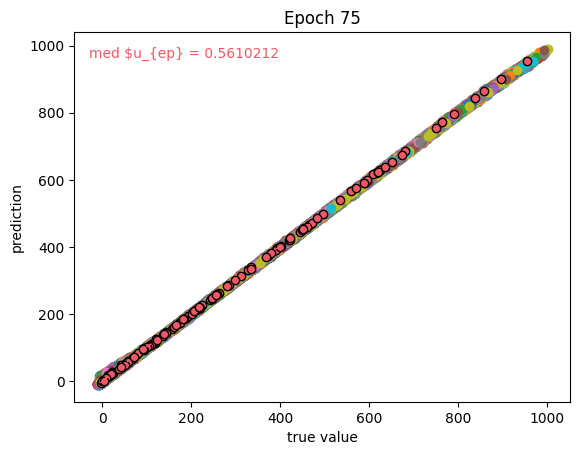

epoch 76 0.15
epoch 77 0.15
epoch 78 0.16
new best loss 1.8559088706970215 in epoch 78
epoch 79 0.16
epoch 80 0.16


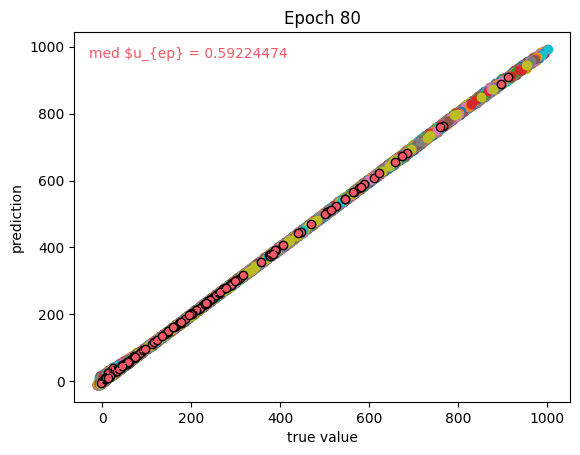

epoch 81 0.16
new best loss 1.8004176616668701 in epoch 81
epoch 82 0.16
epoch 83 0.17
epoch 84 0.17
epoch 85 0.17


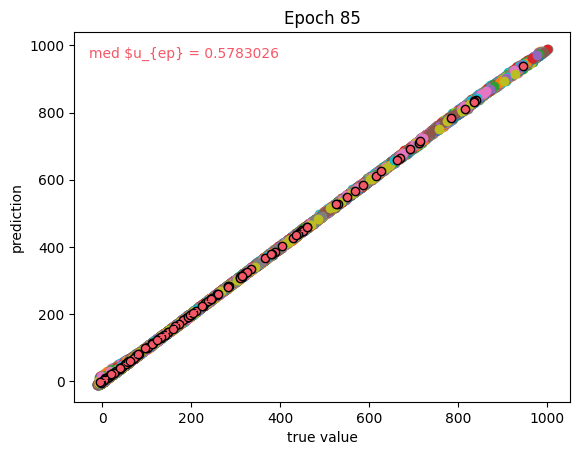

epoch 86 0.17
epoch 87 0.17
epoch 88 0.18
epoch 89 0.18
epoch 90 0.18


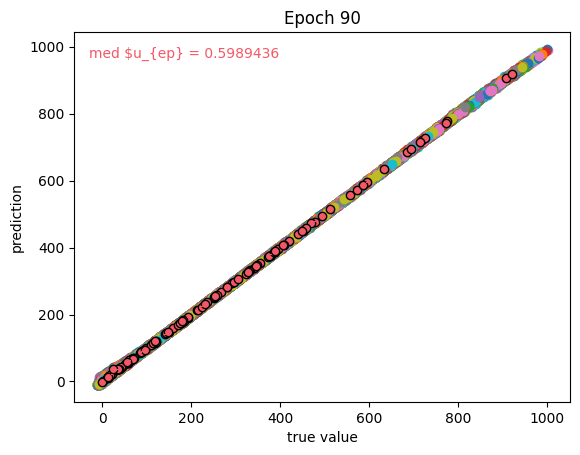

epoch 91 0.18
epoch 92 0.18
epoch 93 0.19
new best loss 1.7205026149749756 in epoch 93
epoch 94 0.19
epoch 95 0.19


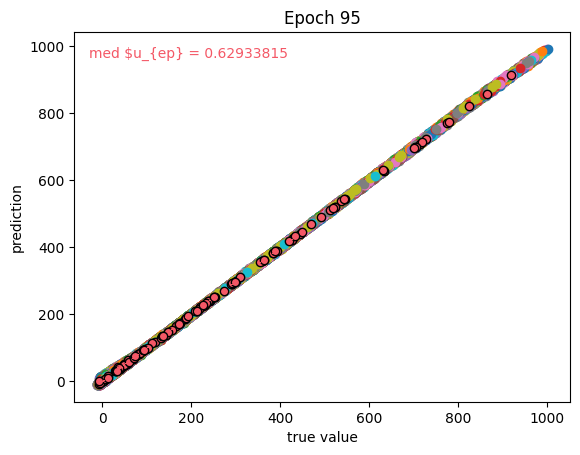

epoch 96 0.19
epoch 97 0.19
epoch 98 0.2
epoch 99 0.2
epoch 100 0.2


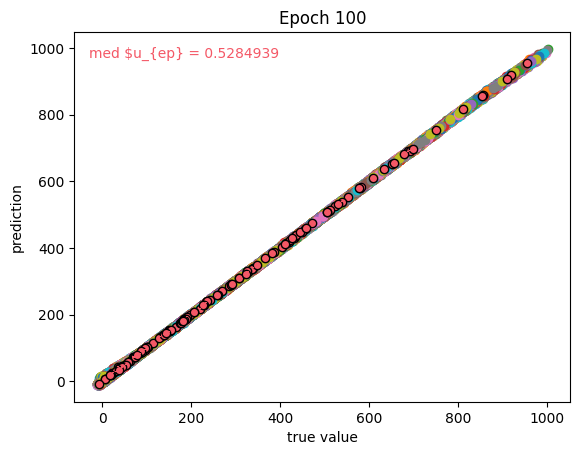

epoch 101 0.2
epoch 102 0.2
epoch 103 0.21
epoch 104 0.21
epoch 105 0.21


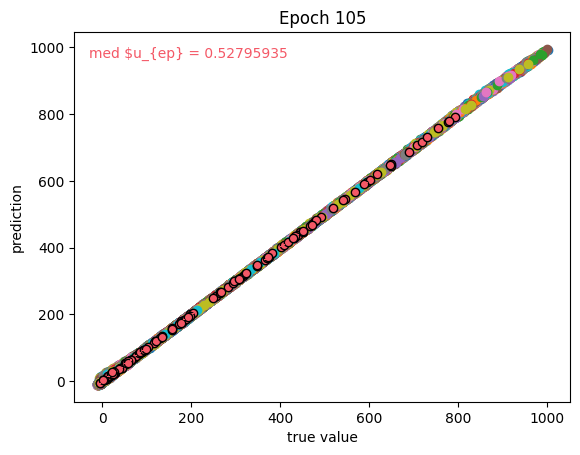

epoch 106 0.21
epoch 107 0.21
epoch 108 0.22
epoch 109 0.22
epoch 110 0.22


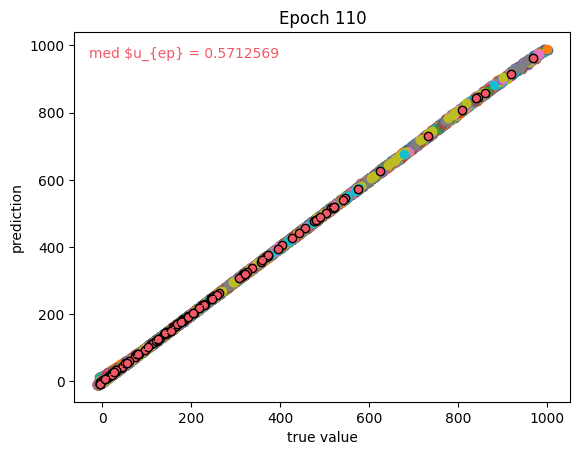

epoch 111 0.22
epoch 112 0.22
new best loss 1.6571218967437744 in epoch 112
epoch 113 0.23
epoch 114 0.23
epoch 115 0.23


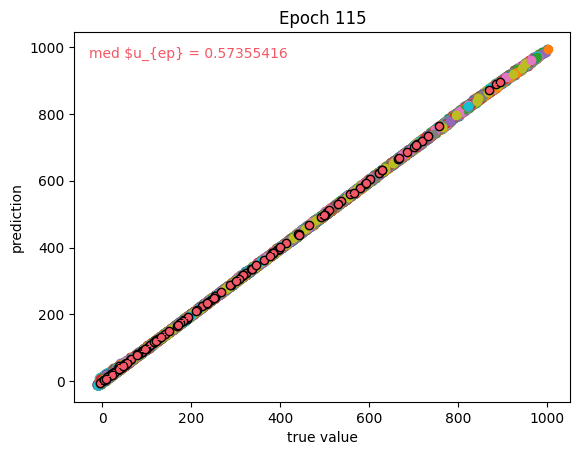

epoch 116 0.23
epoch 117 0.23
epoch 118 0.24
epoch 119 0.24
epoch 120 0.24


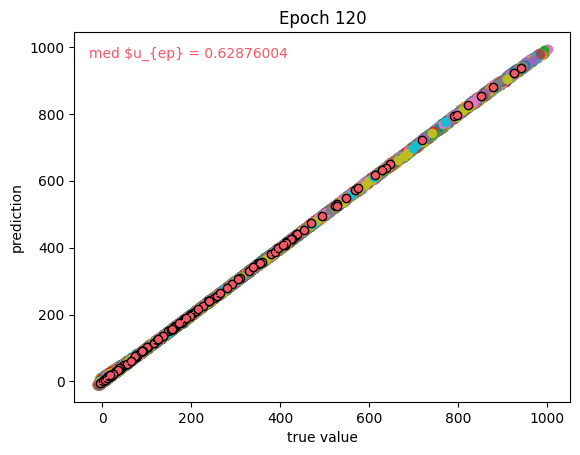

epoch 121 0.24
epoch 122 0.24
epoch 123 0.25
new best loss 1.6517682075500488 in epoch 123
epoch 124 0.25
epoch 125 0.25


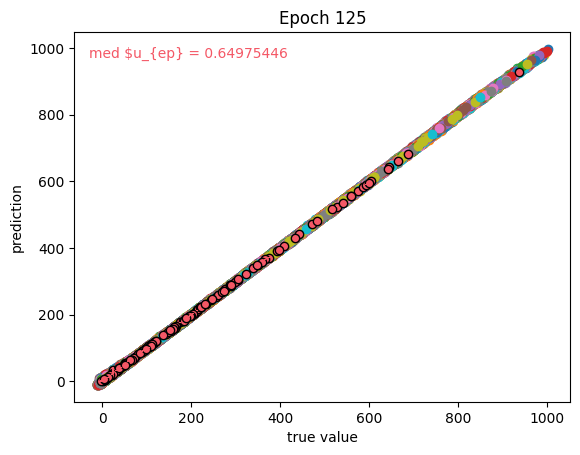

epoch 126 0.25
epoch 127 0.25
epoch 128 0.26
epoch 129 0.26
epoch 130 0.26


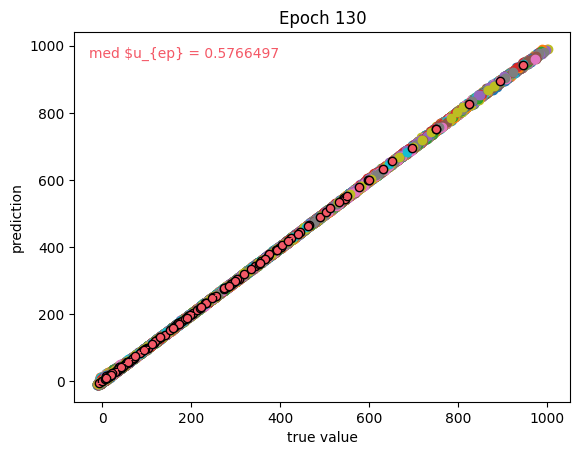

epoch 131 0.26
epoch 132 0.26
epoch 133 0.27
epoch 134 0.27
epoch 135 0.27


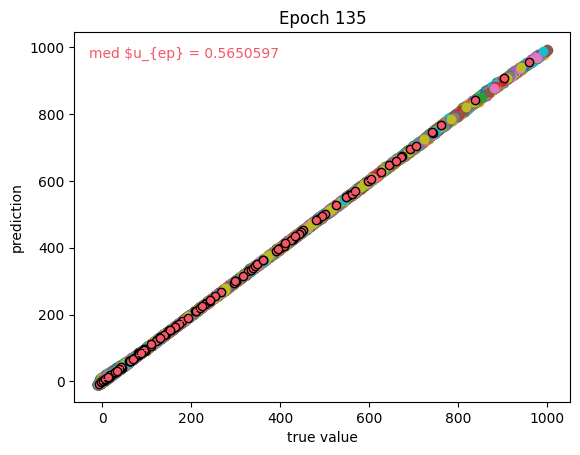

epoch 136 0.27
epoch 137 0.27
epoch 138 0.28
epoch 139 0.28
epoch 140 0.28


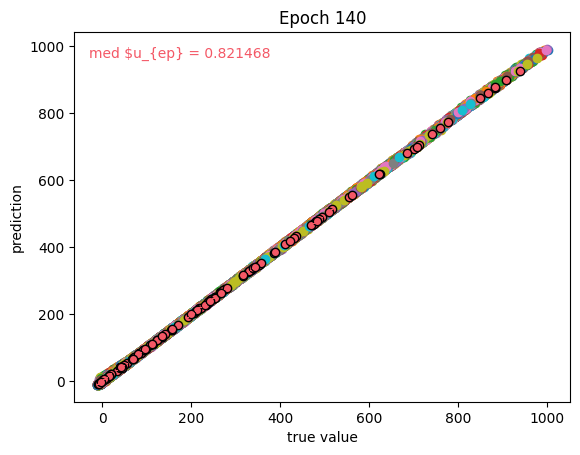

epoch 141 0.28
epoch 142 0.28
epoch 143 0.29
epoch 144 0.29
epoch 145 0.29


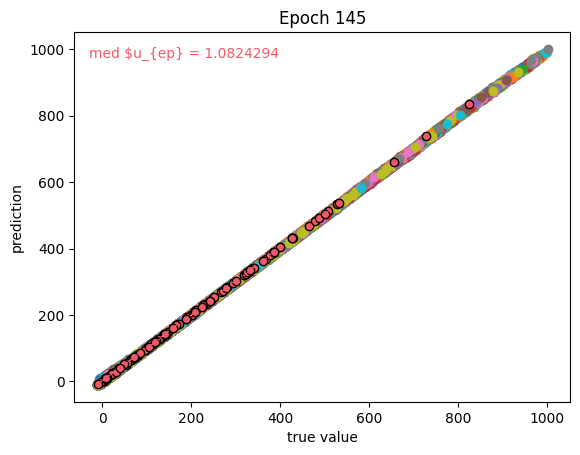

epoch 146 0.29
epoch 147 0.29
epoch 148 0.3
epoch 149 0.3
epoch 150 0.3


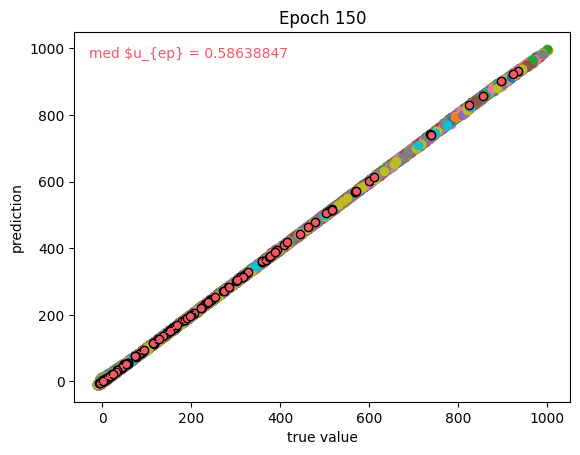

epoch 151 0.3
epoch 152 0.3
epoch 153 0.31
epoch 154 0.31
epoch 155 0.31


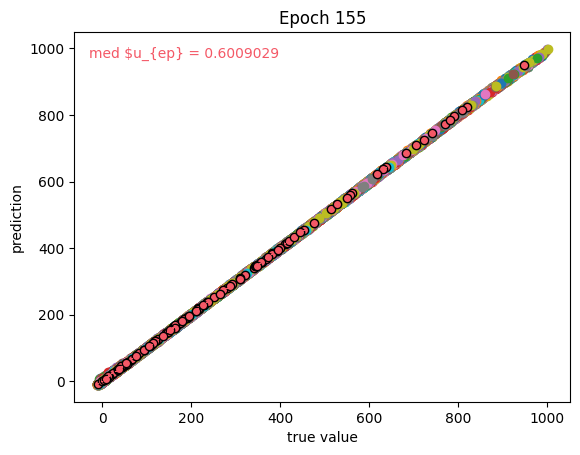

epoch 156 0.31
epoch 157 0.31
epoch 158 0.32
epoch 159 0.32
epoch 160 0.32


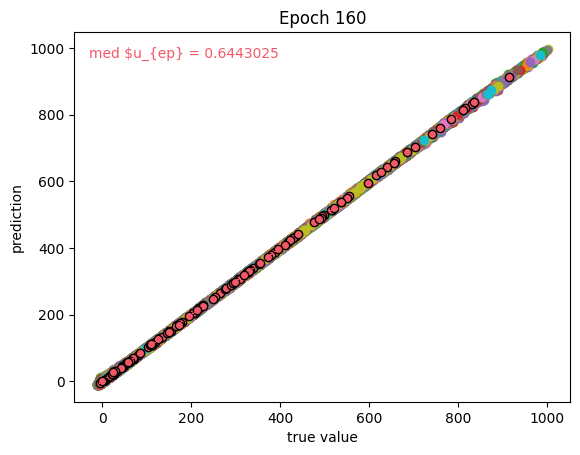

epoch 161 0.32
epoch 162 0.32
epoch 163 0.33
epoch 164 0.33
epoch 165 0.33


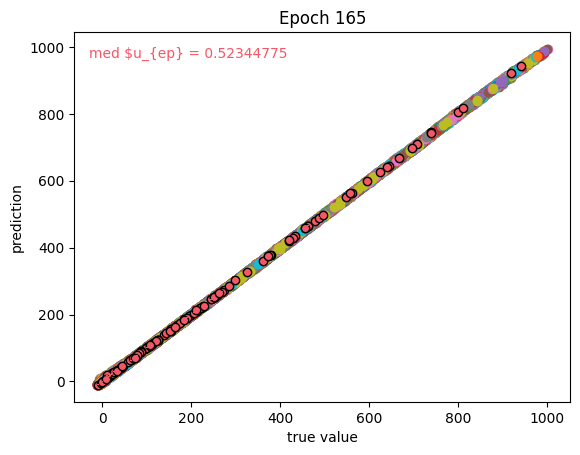

new best loss 1.5880807638168335 in epoch 165
epoch 166 0.33
epoch 167 0.33
epoch 168 0.34
epoch 169 0.34
epoch 170 0.34


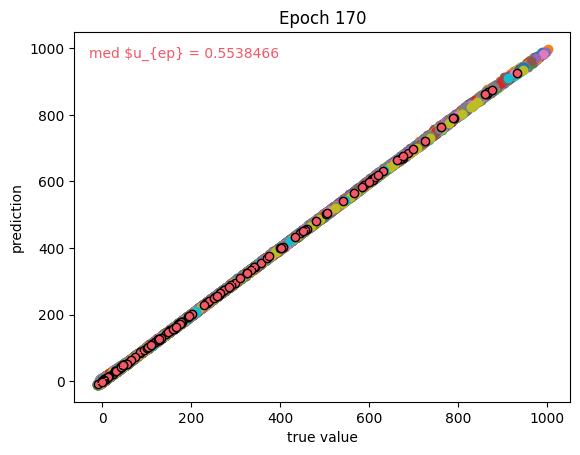

epoch 171 0.34
epoch 172 0.34
epoch 173 0.35
epoch 174 0.35
epoch 175 0.35


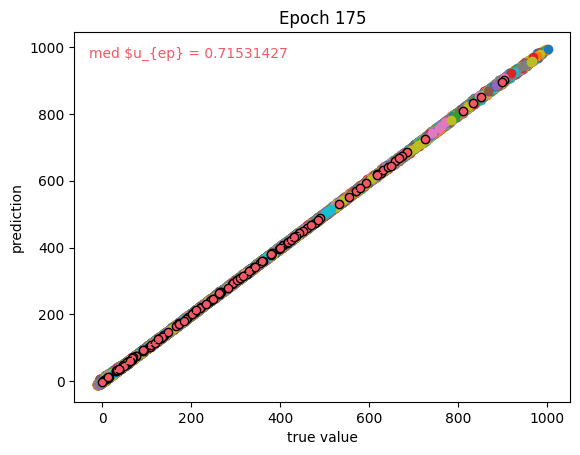

epoch 176 0.35
epoch 177 0.35
epoch 178 0.36
epoch 179 0.36
epoch 180 0.36


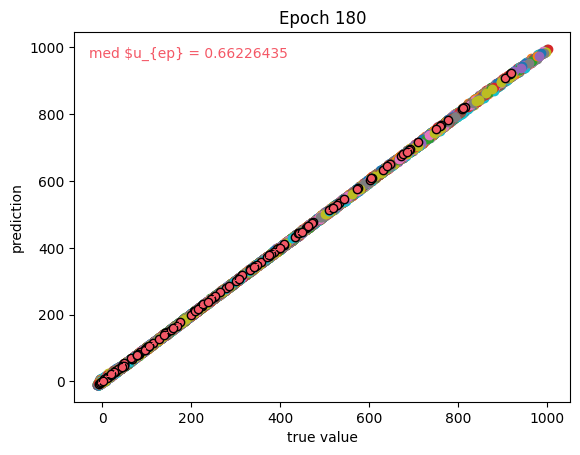

epoch 181 0.36
epoch 182 0.36
epoch 183 0.37
epoch 184 0.37
epoch 185 0.37


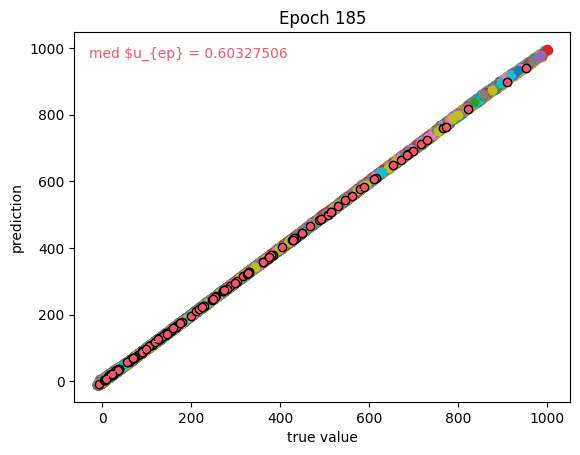

epoch 186 0.37
epoch 187 0.37
epoch 188 0.38
epoch 189 0.38
epoch 190 0.38


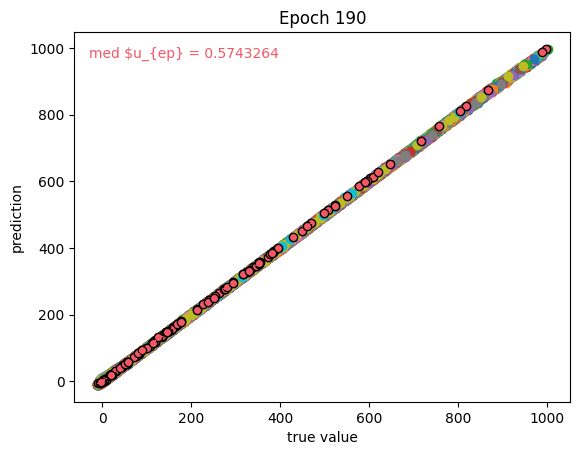

epoch 191 0.38
epoch 192 0.38
new best loss 1.5643303394317627 in epoch 192
epoch 193 0.39
epoch 194 0.39
epoch 195 0.39


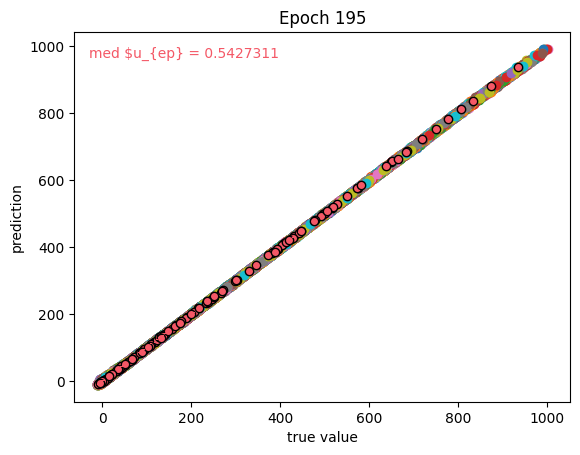

epoch 196 0.39
epoch 197 0.39
epoch 198 0.4
epoch 199 0.4
epoch 200 0.4


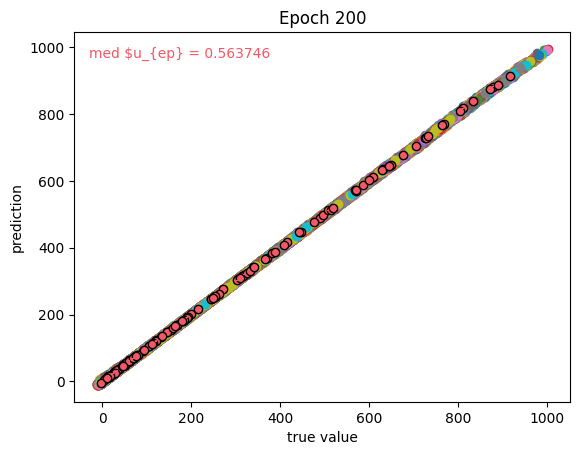

epoch 201 0.4
new best loss 1.5594284534454346 in epoch 201
epoch 202 0.4
epoch 203 0.41
epoch 204 0.41
epoch 205 0.41


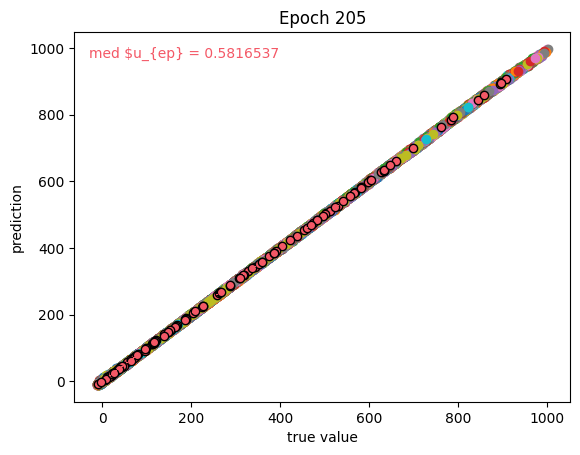

epoch 206 0.41
epoch 207 0.41
epoch 208 0.42
epoch 209 0.42
epoch 210 0.42


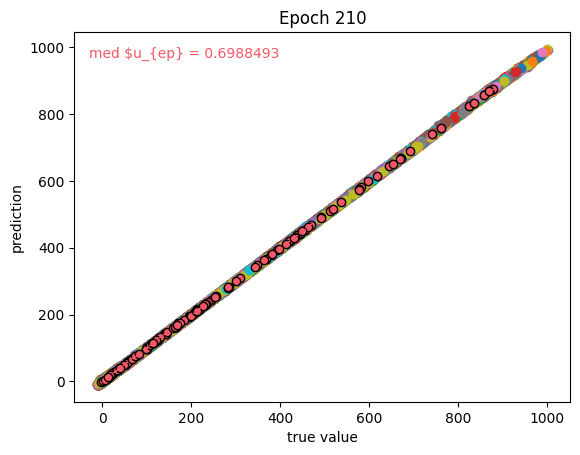

epoch 211 0.42
new best loss 1.5323536396026611 in epoch 211
epoch 212 0.42
epoch 213 0.43
epoch 214 0.43
epoch 215 0.43


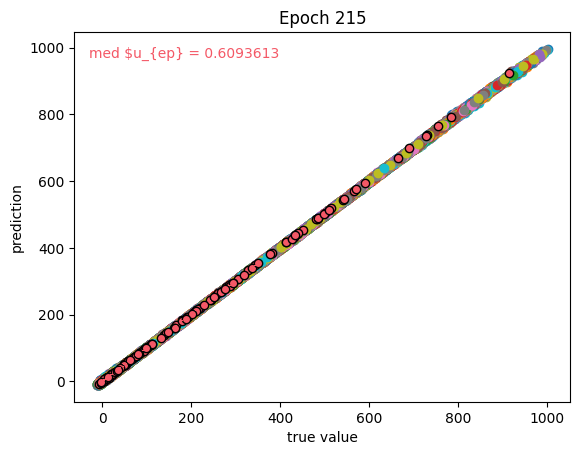

epoch 216 0.43
epoch 217 0.43
epoch 218 0.44
epoch 219 0.44
epoch 220 0.44


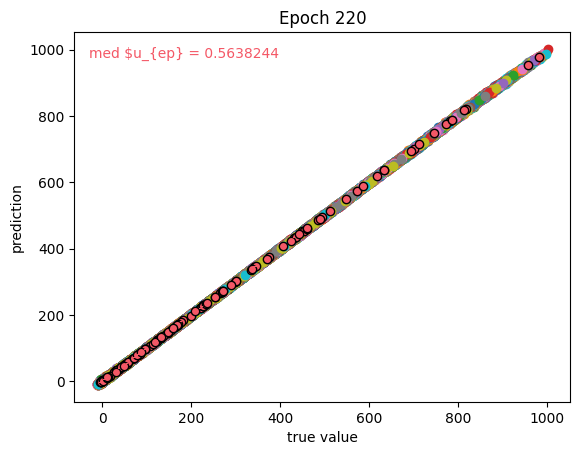

epoch 221 0.44
epoch 222 0.44
epoch 223 0.45
epoch 224 0.45
epoch 225 0.45


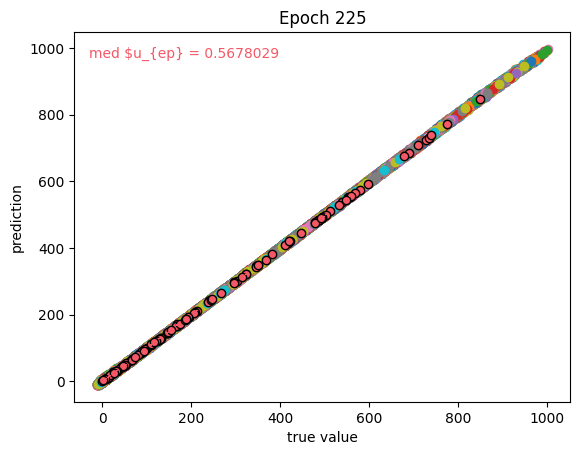

epoch 226 0.45
epoch 227 0.45
epoch 228 0.46
epoch 229 0.46
epoch 230 0.46


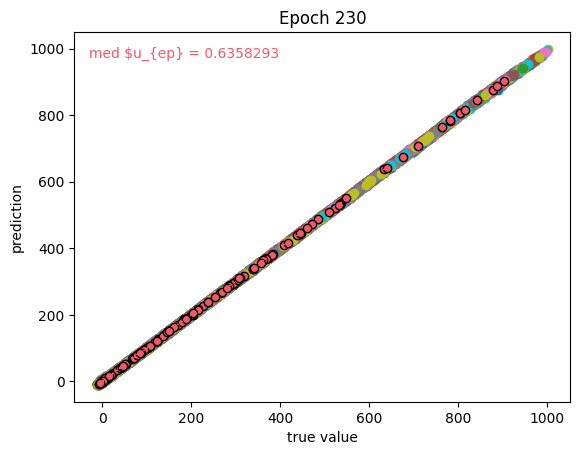

new best loss 1.5166348218917847 in epoch 230
epoch 231 0.46
epoch 232 0.46
new best loss 1.5021916627883911 in epoch 232
epoch 233 0.47
epoch 234 0.47
epoch 235 0.47


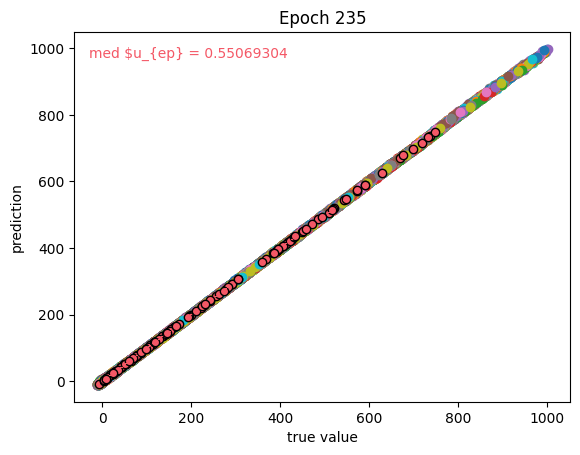

epoch 236 0.47
epoch 237 0.47
epoch 238 0.48
epoch 239 0.48
epoch 240 0.48


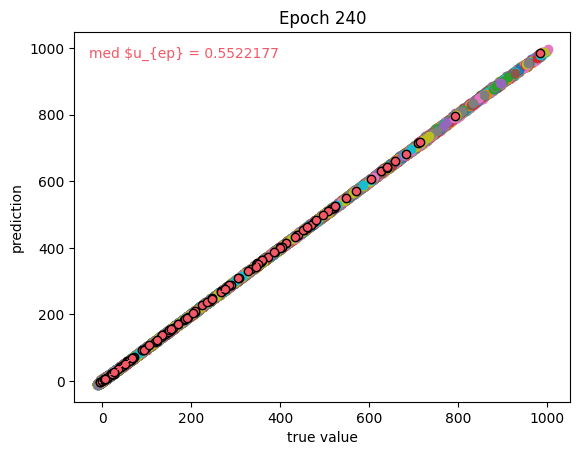

epoch 241 0.48
epoch 242 0.48
epoch 243 0.49
epoch 244 0.49
epoch 245 0.49


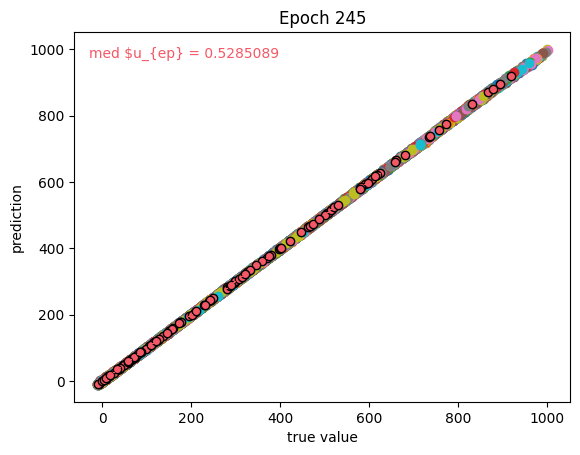

epoch 246 0.49
epoch 247 0.49
epoch 248 0.5
epoch 249 0.5
epoch 250 0.5


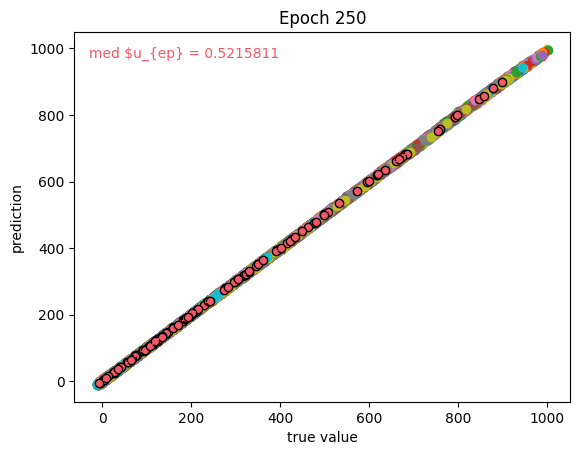

epoch 251 0.5
epoch 252 0.5
epoch 253 0.51
epoch 254 0.51
epoch 255 0.51


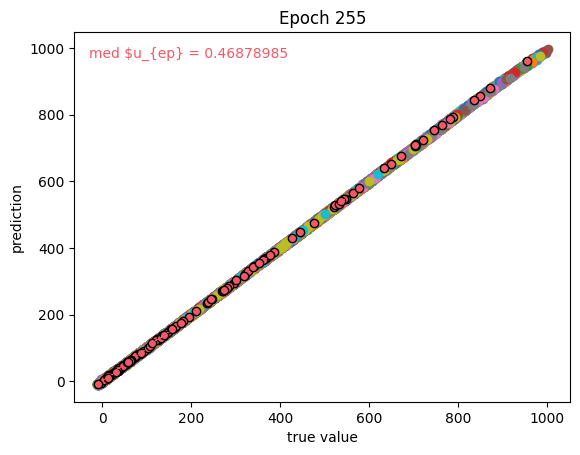

epoch 256 0.51
epoch 257 0.51
epoch 258 0.52
epoch 259 0.52
epoch 260 0.52


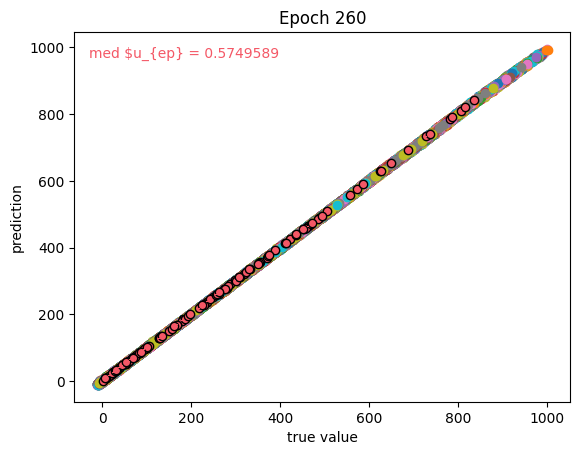

epoch 261 0.52
epoch 262 0.52
epoch 263 0.53
epoch 264 0.53
epoch 265 0.53


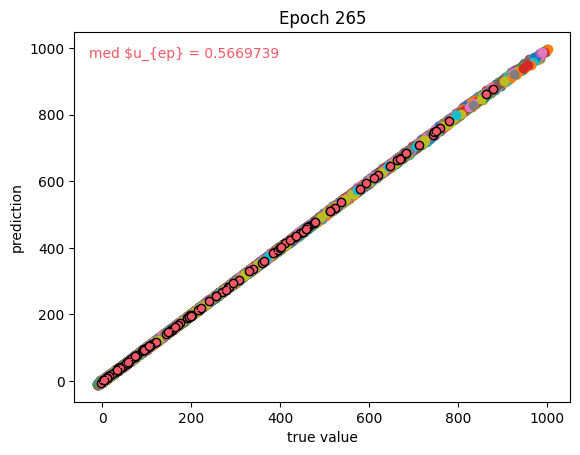

epoch 266 0.53
epoch 267 0.53
epoch 268 0.54
epoch 269 0.54
epoch 270 0.54


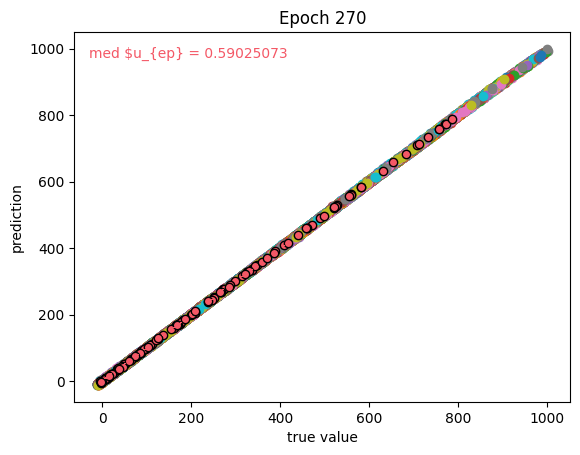

new best loss 1.4490634202957153 in epoch 270
epoch 271 0.54
epoch 272 0.54
epoch 273 0.55
epoch 274 0.55
epoch 275 0.55


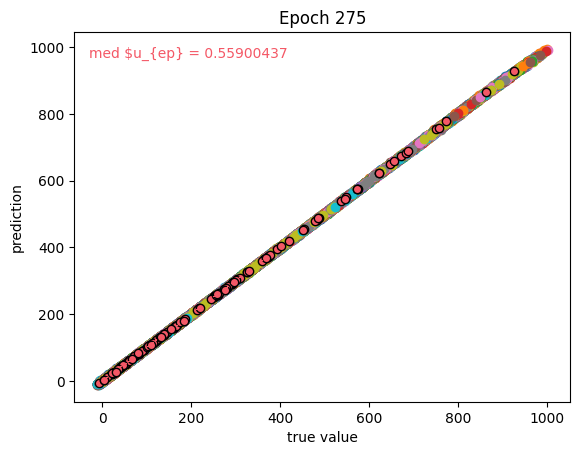

epoch 276 0.55
epoch 277 0.55
epoch 278 0.56
epoch 279 0.56
epoch 280 0.56


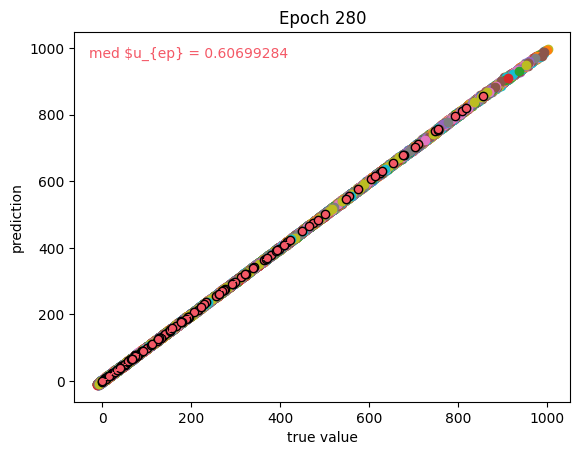

epoch 281 0.56
epoch 282 0.56
epoch 283 0.57
epoch 284 0.57
epoch 285 0.57


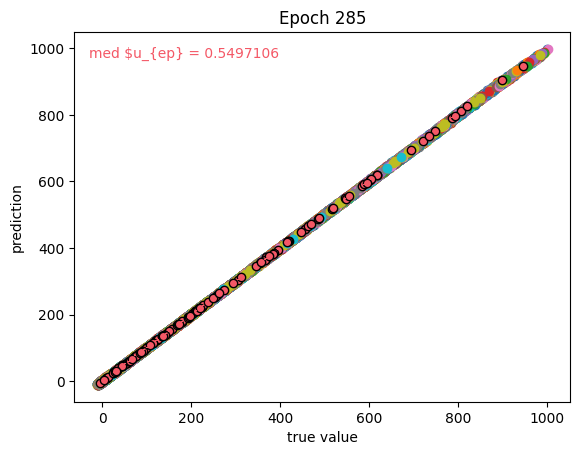

epoch 286 0.57
epoch 287 0.57
epoch 288 0.58
epoch 289 0.58
epoch 290 0.58


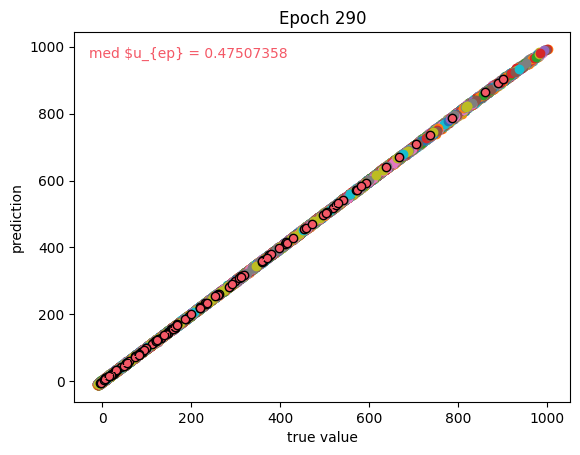

epoch 291 0.58
epoch 292 0.58
epoch 293 0.59
epoch 294 0.59
epoch 295 0.59


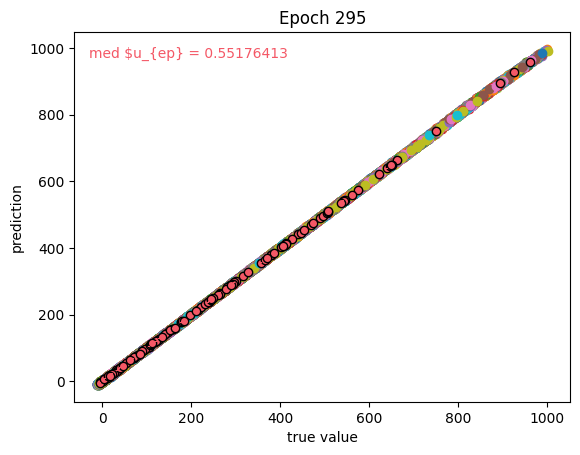

epoch 296 0.59
epoch 297 0.59
epoch 298 0.6
epoch 299 0.6
epoch 300 0.6


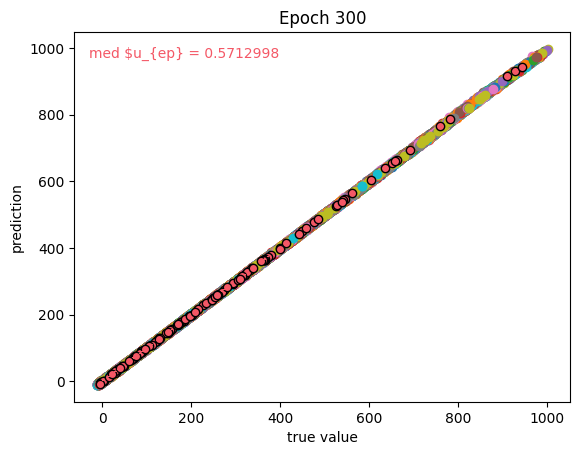

epoch 301 0.6
epoch 302 0.6
epoch 303 0.61
epoch 304 0.61
epoch 305 0.61


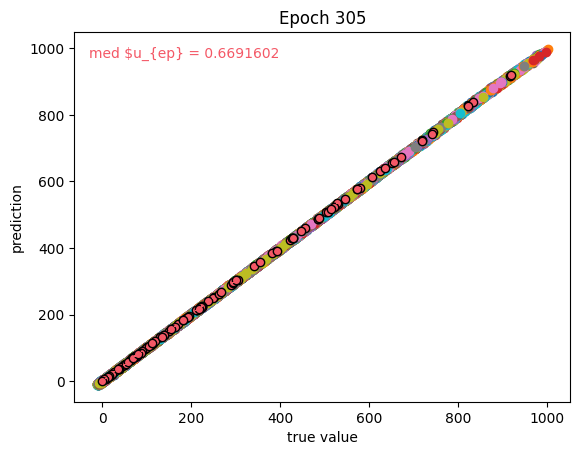

epoch 306 0.61
epoch 307 0.61
epoch 308 0.62
epoch 309 0.62
epoch 310 0.62


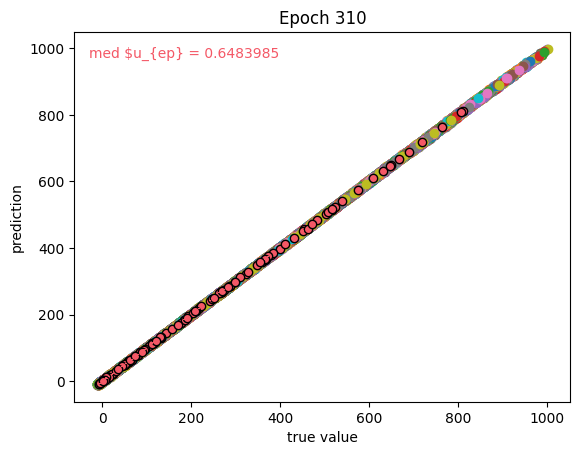

epoch 311 0.62
epoch 312 0.62
new best loss 1.4277260303497314 in epoch 312
epoch 313 0.63
epoch 314 0.63
epoch 315 0.63


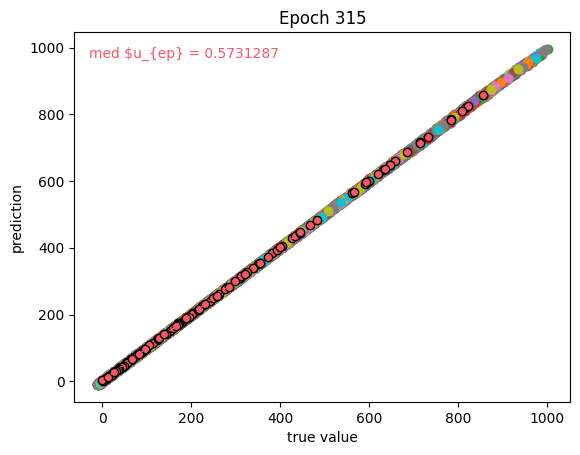

epoch 316 0.63
epoch 317 0.63
epoch 318 0.64
epoch 319 0.64
epoch 320 0.64


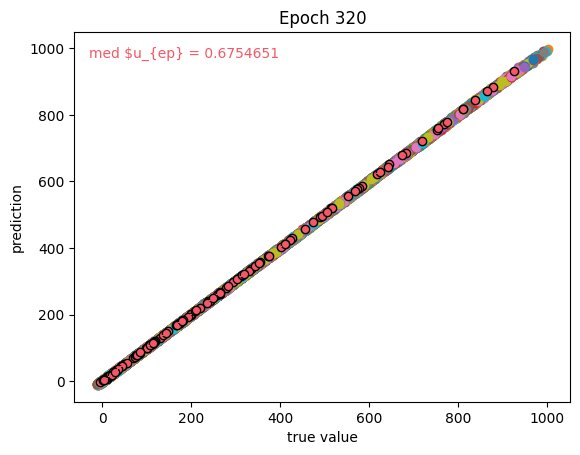

epoch 321 0.64
epoch 322 0.64
epoch 323 0.65
epoch 324 0.65
epoch 325 0.65


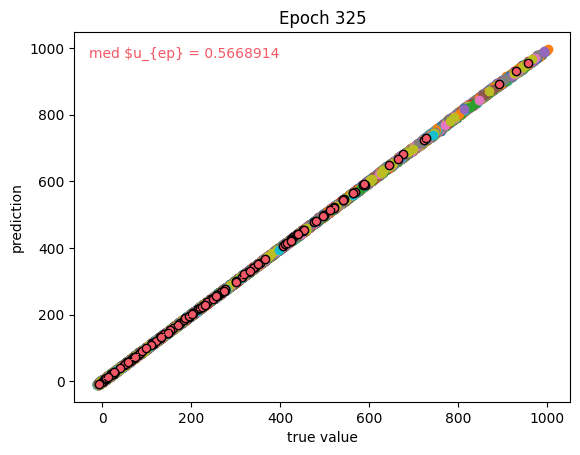

epoch 326 0.65
epoch 327 0.65
epoch 328 0.66
epoch 329 0.66
epoch 330 0.66


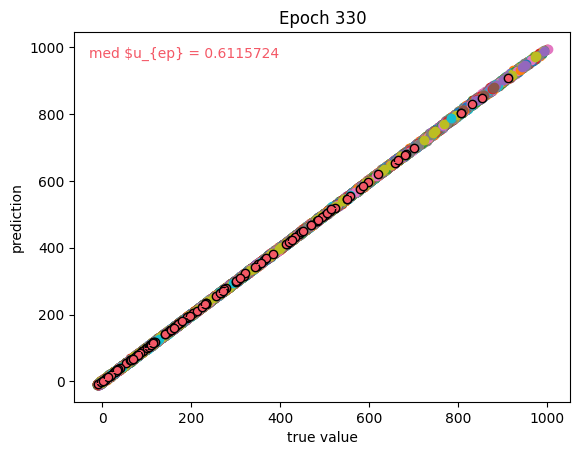

epoch 331 0.66
epoch 332 0.66
epoch 333 0.67
epoch 334 0.67
epoch 335 0.67


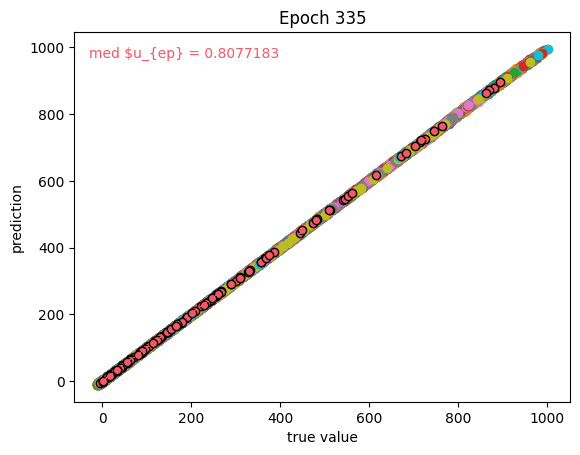

epoch 336 0.67
epoch 337 0.67
epoch 338 0.68
epoch 339 0.68
epoch 340 0.68


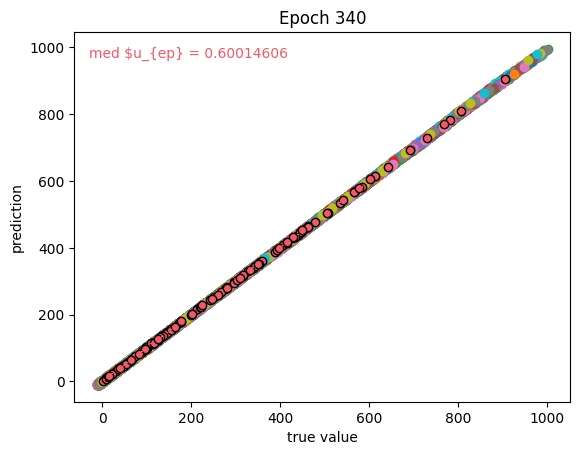

epoch 341 0.68
epoch 342 0.68
new best loss 1.4107697010040283 in epoch 342
epoch 343 0.69
epoch 344 0.69
epoch 345 0.69


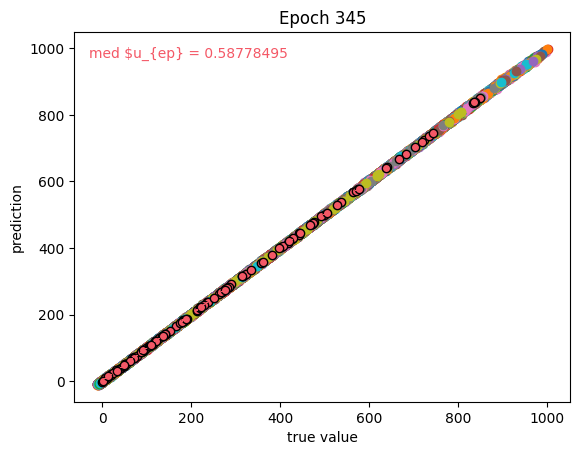

new best loss 1.3939497470855713 in epoch 345
epoch 346 0.69
epoch 347 0.69
epoch 348 0.7
epoch 349 0.7
epoch 350 0.7


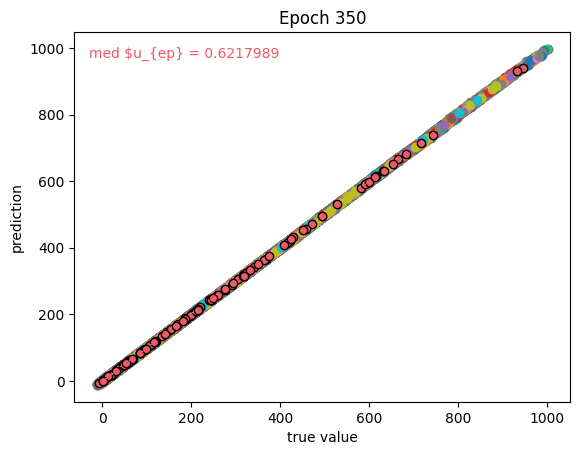

epoch 351 0.7
epoch 352 0.7
epoch 353 0.71
epoch 354 0.71
epoch 355 0.71


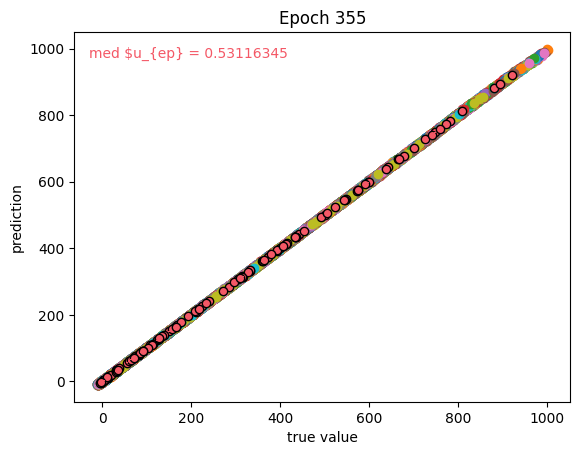

epoch 356 0.71
epoch 357 0.71
epoch 358 0.72
epoch 359 0.72
epoch 360 0.72


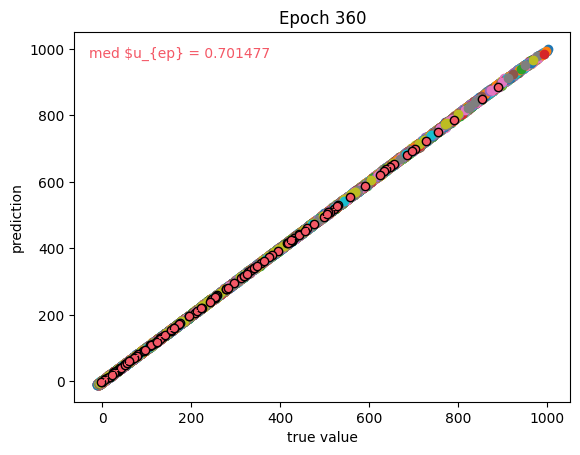

epoch 361 0.72
epoch 362 0.72
epoch 363 0.73
epoch 364 0.73
epoch 365 0.73


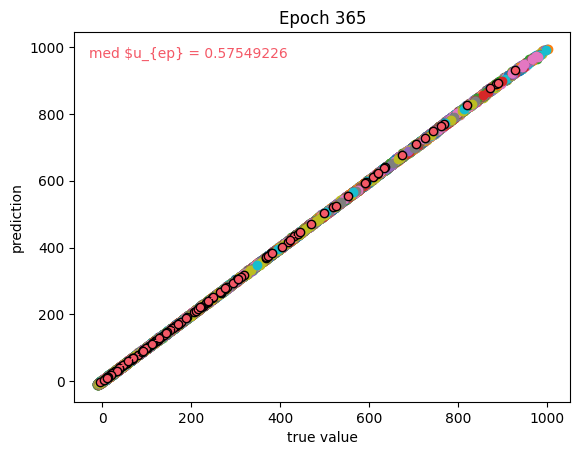

epoch 366 0.73
epoch 367 0.73
epoch 368 0.74
epoch 369 0.74
epoch 370 0.74


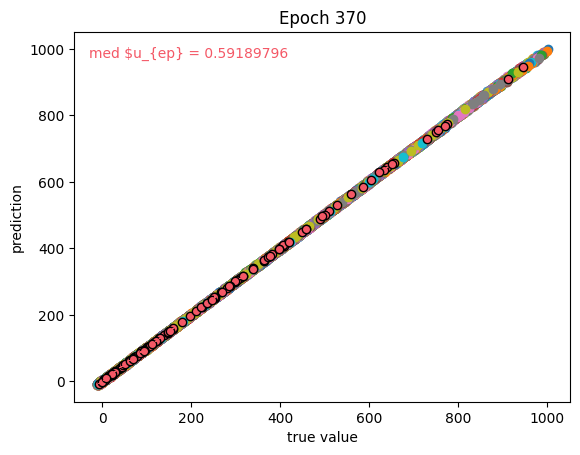

epoch 371 0.74
epoch 372 0.74
epoch 373 0.75
epoch 374 0.75
epoch 375 0.75


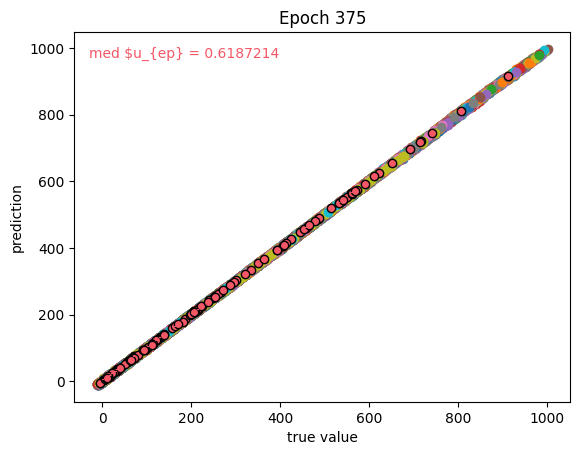

epoch 376 0.75
epoch 377 0.75
epoch 378 0.76
epoch 379 0.76
epoch 380 0.76


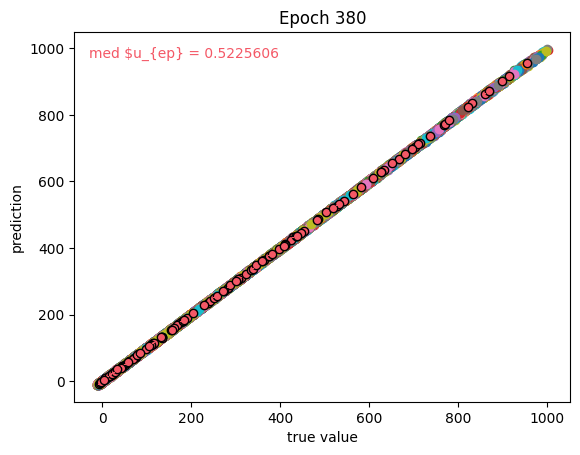

epoch 381 0.76
epoch 382 0.76
epoch 383 0.77
epoch 384 0.77
epoch 385 0.77


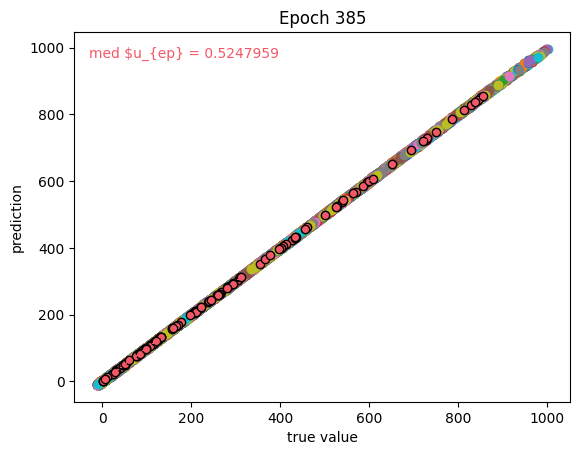

epoch 386 0.77
epoch 387 0.77
epoch 388 0.78
epoch 389 0.78
epoch 390 0.78


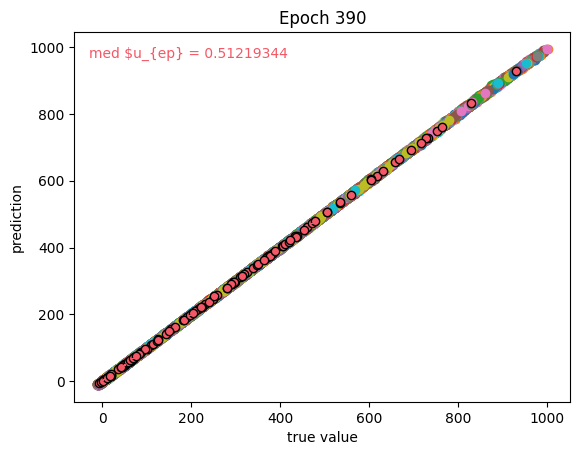

epoch 391 0.78
epoch 392 0.78
new best loss 1.3816335201263428 in epoch 392
epoch 393 0.79
epoch 394 0.79
epoch 395 0.79


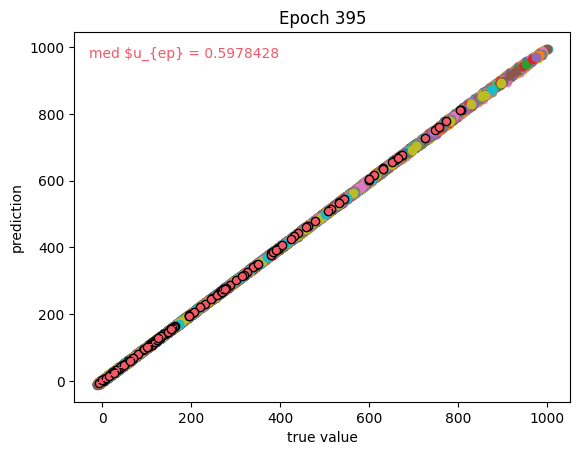

epoch 396 0.79
epoch 397 0.79
epoch 398 0.8
epoch 399 0.8
epoch 400 0.8


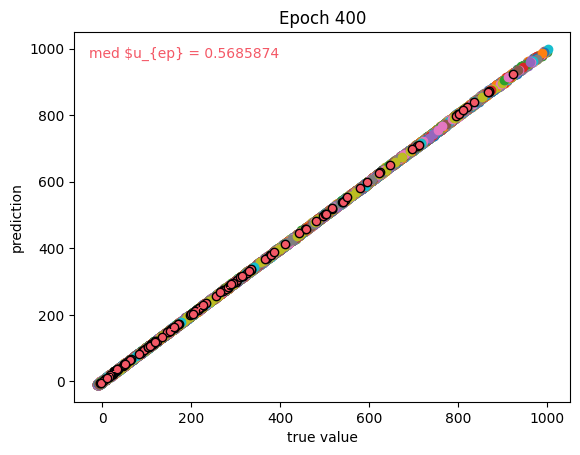

epoch 401 0.8
epoch 402 0.8
epoch 403 0.81
epoch 404 0.81
epoch 405 0.81


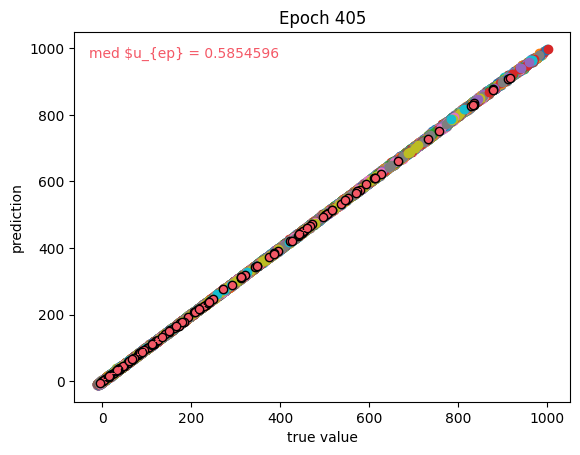

epoch 406 0.81
epoch 407 0.81
epoch 408 0.82
epoch 409 0.82
epoch 410 0.82


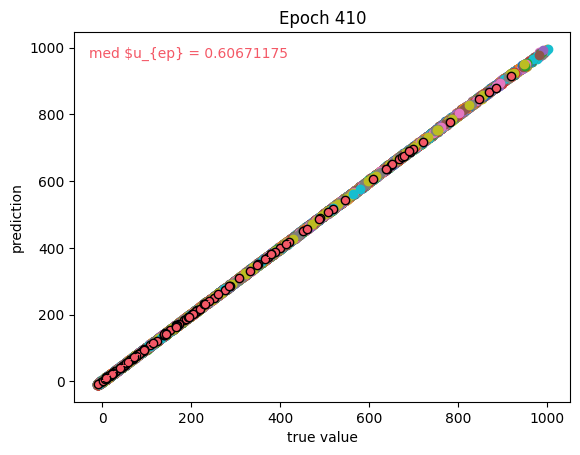

epoch 411 0.82
epoch 412 0.82
epoch 413 0.83
epoch 414 0.83
new best loss 1.3639193773269653 in epoch 414
epoch 415 0.83


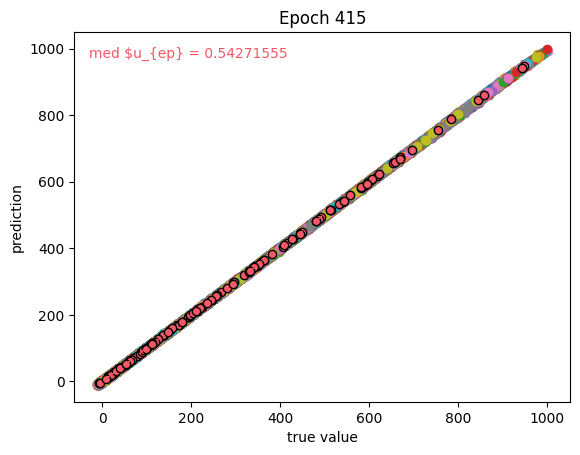

epoch 416 0.83
epoch 417 0.83
epoch 418 0.84
epoch 419 0.84
epoch 420 0.84


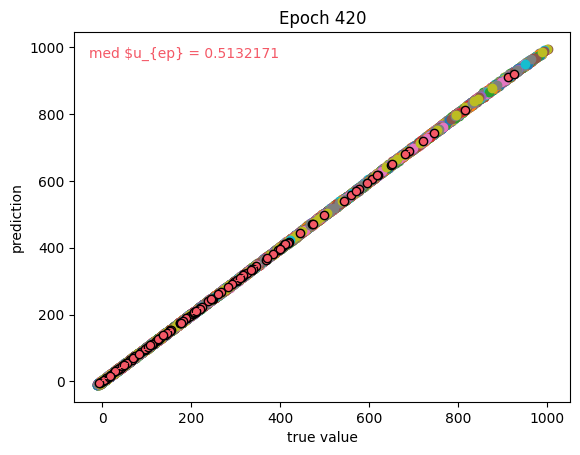

epoch 421 0.84
epoch 422 0.84
epoch 423 0.85
epoch 424 0.85
epoch 425 0.85


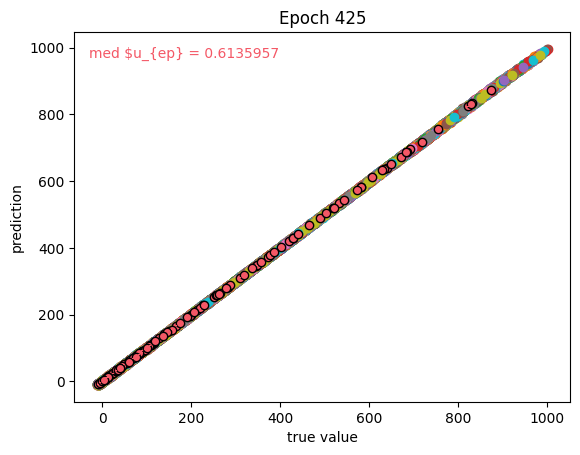

epoch 426 0.85
epoch 427 0.85
epoch 428 0.86
new best loss 1.3525792360305786 in epoch 428
epoch 429 0.86
epoch 430 0.86


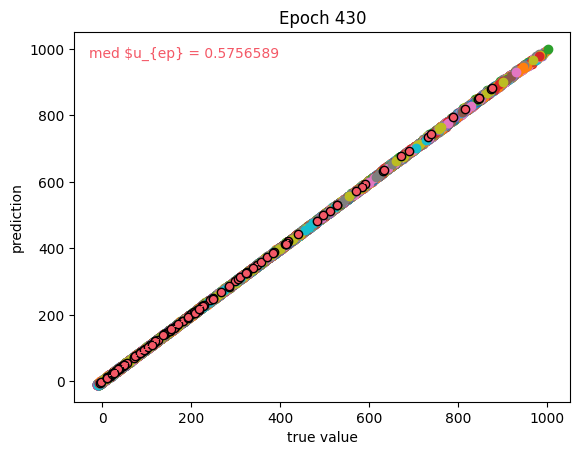

epoch 431 0.86
epoch 432 0.86
epoch 433 0.87
epoch 434 0.87
epoch 435 0.87


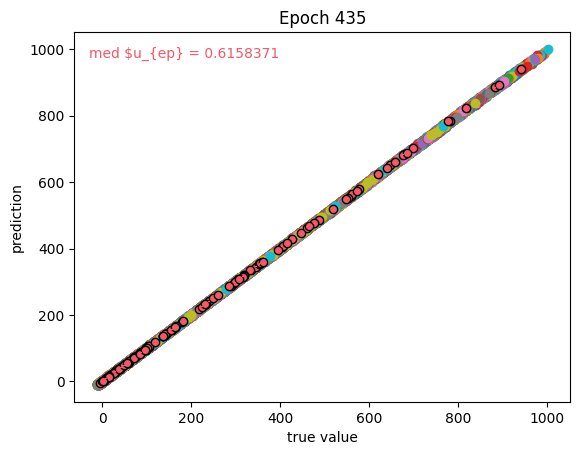

epoch 436 0.87
epoch 437 0.87
epoch 438 0.88
epoch 439 0.88
epoch 440 0.88


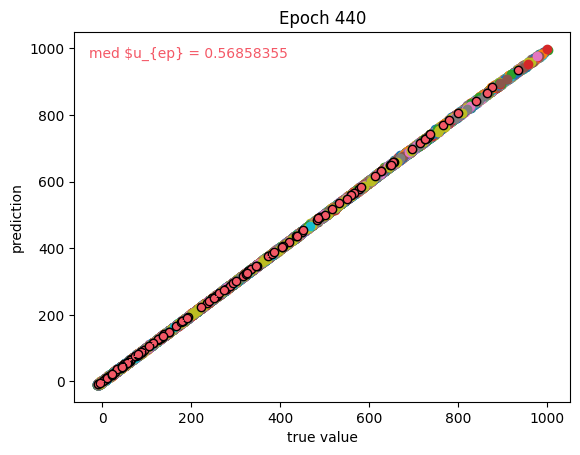

epoch 441 0.88
epoch 442 0.88
epoch 443 0.89
epoch 444 0.89
epoch 445 0.89


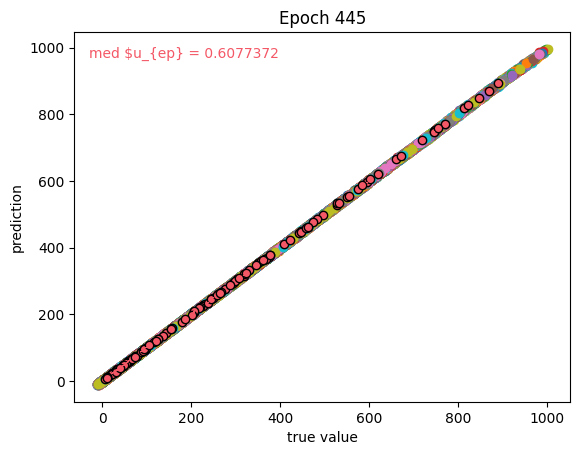

epoch 446 0.89
epoch 447 0.89
epoch 448 0.9
epoch 449 0.9
epoch 450 0.9


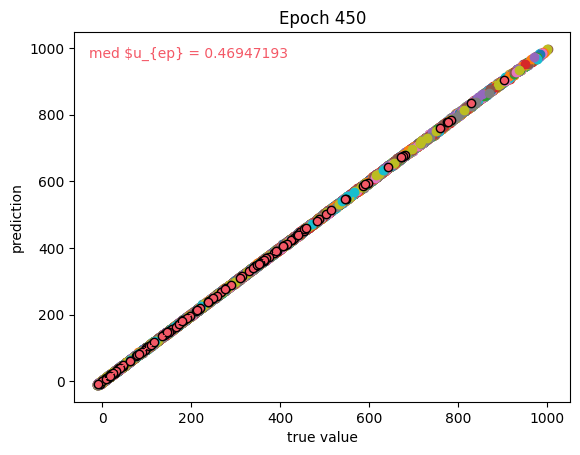

epoch 451 0.9
epoch 452 0.9
epoch 453 0.91
epoch 454 0.91
epoch 455 0.91


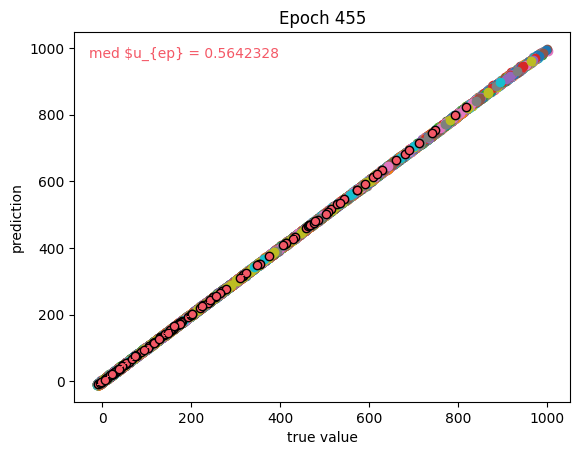

epoch 456 0.91
epoch 457 0.91
epoch 458 0.92
epoch 459 0.92
epoch 460 0.92


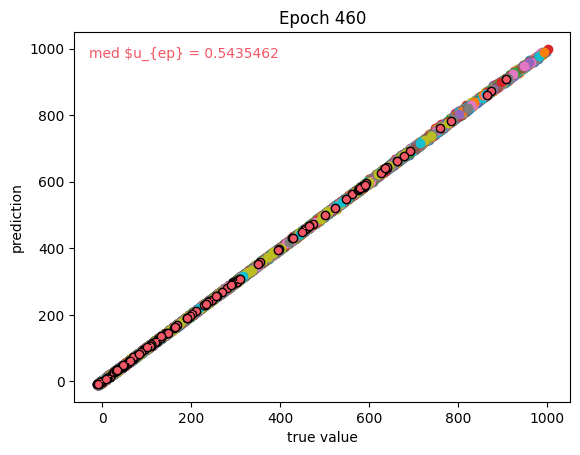

epoch 461 0.92
epoch 462 0.92
epoch 463 0.93
epoch 464 0.93
epoch 465 0.93


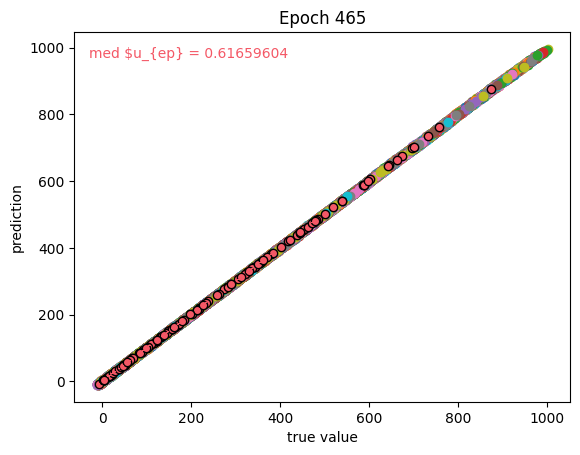

epoch 466 0.93
epoch 467 0.93
epoch 468 0.94
epoch 469 0.94
epoch 470 0.94


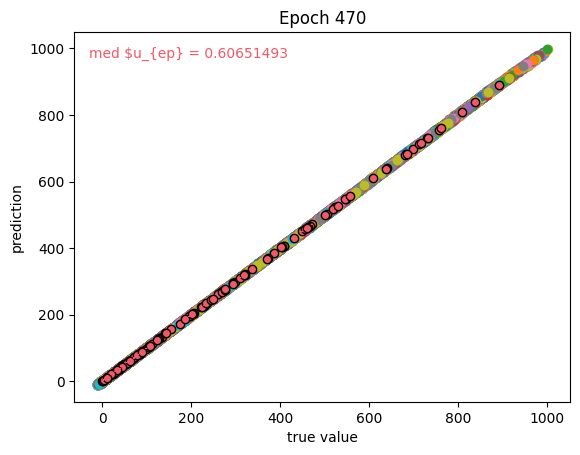

epoch 471 0.94
new best loss 1.3266913890838623 in epoch 471
epoch 472 0.94
epoch 473 0.95
epoch 474 0.95
epoch 475 0.95


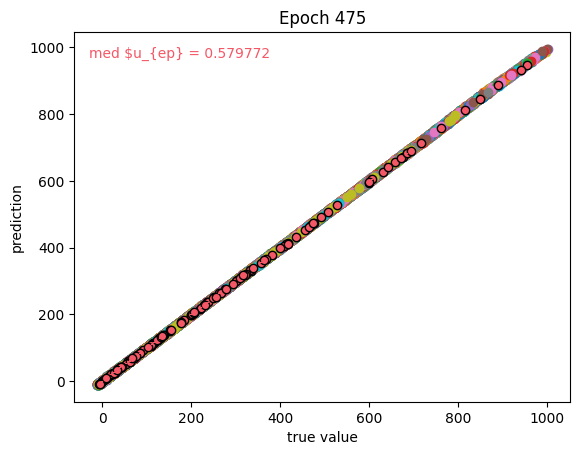

epoch 476 0.95
epoch 477 0.95
epoch 478 0.96
epoch 479 0.96
epoch 480 0.96


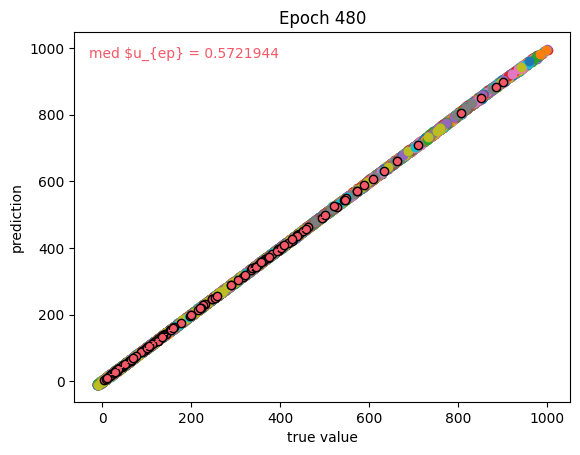

epoch 481 0.96
epoch 482 0.96
epoch 483 0.97
epoch 484 0.97
epoch 485 0.97


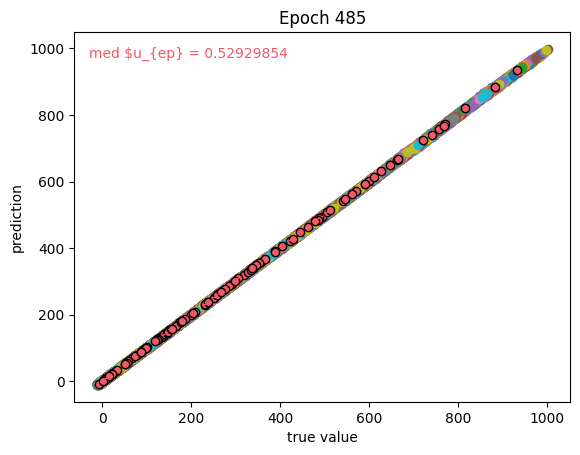

epoch 486 0.97
epoch 487 0.97
epoch 488 0.98
epoch 489 0.98
epoch 490 0.98


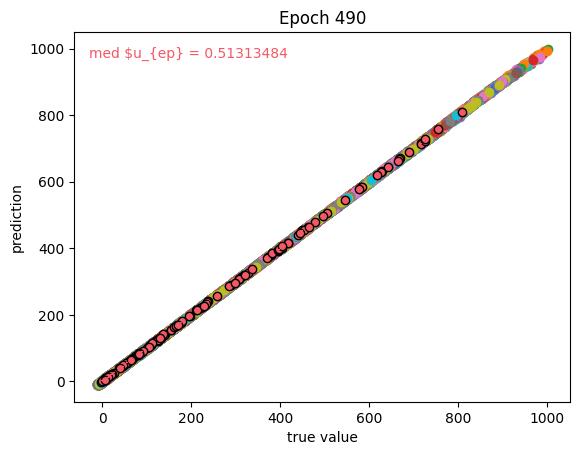

epoch 491 0.98
epoch 492 0.98
epoch 493 0.99
epoch 494 0.99
epoch 495 0.99


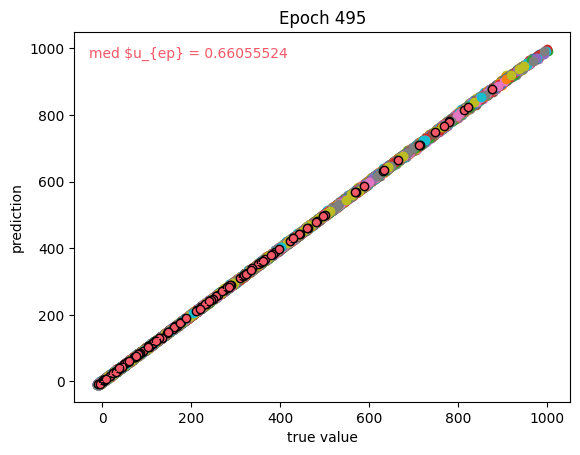

epoch 496 0.99
epoch 497 0.99
epoch 498 1.0
epoch 499 1.0
start at 1707853298.265072 end at 1707853809.1692748
510.90420269966125


<Figure size 640x480 with 0 Axes>

In [46]:
# my own training model
INIT_LR = LR
model_ensemble = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_TYPE,
             model_name,
             EPOCHS=n_epochs,
             save_checkpoints=True,
             path_to_model='../models/',
             plot=True)
 

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [ ]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model = model_ensemble
model.eval()
# first, normalize the x value using the xmin and xmax before
if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    # I think I'm doing the un-normalization wrong for the other terms in the output:
    aleatoric_OG = np.sqrt((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) - 1))
    aleatoric_mod = np.sqrt(((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) * (1 + (y_norm_pred[:,1] * (outputmax - outputmin) + outputmin))) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) * (y_norm_pred[:,1]* (outputmax - outputmin) + outputmin)))
    epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])
else:
    y_pred_all_terms = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = y_pred_all_terms[:,0]
    aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
    aleatoric_mod = np.sqrt((y_pred_all_terms[:,3]  * (1 + y_pred_all_terms[:,1] )) / (y_pred_all_terms[:,2] * y_pred_all_terms[:,1]))
    epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_pred_all_terms[:,1])

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = r'$u_{al}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax1.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax1.set_title('Aleatoric Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = aleatoric_mod,
             label = r'$u_{al}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax2.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax2.set_title('Aleatoric Error Meinert+2022')
plt.show()

### Now epistemic

In [ ]:
print, epistemic_OG, epistemic_mod 

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = epistemic_OG,
             label = r'$u_{ep}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax1.set_title('Epistemic Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = epistemic_mod,
             label = r'$u_{ep}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax2.set_title('Epistemic Error Meinert+2022')
plt.show()
